### Решение Хакатона от Finam трек Forecast

### BaseLine от организаторов

In [21]:
"""
Baseline решение для соревнования.

Простое решение без использования ML:
- Используем скользящее среднее последних N дней
- Предсказываем направление на основе моментума
- Это baseline для сравнения с более сложными решениями
"""

from pathlib import Path

import numpy as np
import pandas as pd


class BaselineSolution:
    """
    Baseline решение на основе скользящих средних и моментума

    Логика:
    1. Для каждого тикера вычисляем моментум (изменение цены за последние N дней)
    2. Предсказываем, что тренд продолжится (momentum continuation)
    3. Вероятность роста = сигмоида от моментума
    """

    def __init__(self, window_size: int = 5):
        """
        Args:
            window_size: Размер окна для вычисления моментума
        """
        self.window_size = window_size

    def load_data(self, train_candles_path: str,
                  public_test_path: str,
                  private_test_path: str):
        """Загрузка данных"""
        print("📊 Загрузка данных...")

        self.train_df = pd.read_csv(train_candles_path)
        self.train_df['begin'] = pd.to_datetime(self.train_df['begin'])

        public_test_df = pd.read_csv(public_test_path)
        public_test_df['begin'] = pd.to_datetime(public_test_df['begin'])

        private_test_df = pd.read_csv(private_test_path)
        private_test_df['begin'] = pd.to_datetime(private_test_df['begin'])

        # Объединяем оба теста
        self.test_df = pd.concat([public_test_df, private_test_df], ignore_index=True)

        # Объединяем для вычисления моментума (нужна история)
        self.full_df = pd.concat([self.train_df, self.test_df], ignore_index=True)
        self.full_df = self.full_df.sort_values(['ticker', 'begin'])

        print(f"   ✓ Train: {len(self.train_df)} строк")
        print(f"   ✓ Public test:  {len(public_test_df)} строк")
        print(f"   ✓ Private test: {len(private_test_df)} строк")
        print(f"   ✓ Total test:   {len(self.test_df)} строк")

    def compute_features(self):
        """Вычисление признаков (моментум, волатильность)"""
        print("\n🔧 Вычисление признаков...")

        df = self.full_df.copy()

        # Группируем по тикерам
        for ticker in df['ticker'].unique():
            mask = df['ticker'] == ticker
            ticker_data = df[mask].copy()

            # 1. Моментум = процентное изменение цены за window_size дней
            ticker_data['momentum'] = (
                ticker_data['close'].pct_change(self.window_size)
            )

            # 2. Волатильность = std доходностей за window_size дней
            ticker_data['volatility'] = (
                ticker_data['close'].pct_change().rolling(self.window_size).std()
            )

            # 3. Средняя цена за window_size дней
            ticker_data['ma'] = ticker_data['close'].rolling(self.window_size).mean()

            # 4. Расстояние от MA (нормализованное)
            ticker_data['distance_from_ma'] = (
                (ticker_data['close'] - ticker_data['ma']) / ticker_data['ma']
            )

            # Обновляем данные
            df.loc[mask, 'momentum'] = ticker_data['momentum'].values
            df.loc[mask, 'volatility'] = ticker_data['volatility'].values
            df.loc[mask, 'ma'] = ticker_data['ma'].values
            df.loc[mask, 'distance_from_ma'] = ticker_data['distance_from_ma'].values

        self.full_df = df
        print("   ✓ Признаки вычислены")

    def predict(self):
        """
        Создание предсказаний

        Baseline стратегия:
        - pred_return = momentum * scaling_factor
        - pred_prob_up = sigmoid(momentum * sensitivity)
        """
        print("\n🎯 Создание предсказаний...")

        # Фильтруем только test данные
        test_data = self.full_df[
            self.full_df['begin'].isin(self.test_df['begin'])
        ].copy()

        # Заполняем NaN нулями (для первых строк где нет истории)
        test_data['momentum'] = test_data['momentum'].fillna(0)
        test_data['volatility'] = test_data['volatility'].fillna(0.01)
        test_data['distance_from_ma'] = test_data['distance_from_ma'].fillna(0)

        # Предсказание доходности
        # Простая стратегия: предсказываем что моментум продолжится
        # Для 1 дня: momentum * 0.3 (ослабляем сигнал)
        # Для 20 дней: momentum * 1.0 (накопленный эффект)
        test_data['pred_return_1d'] = test_data['momentum'] * 0.3
        test_data['pred_return_20d'] = test_data['momentum'] * 1.0

        # Предсказание вероятности роста
        # Используем сигмоиду для преобразования моментума в вероятность
        def sigmoid(x, sensitivity=10):
            return 1 / (1 + np.exp(-sensitivity * x))

        test_data['pred_prob_up_1d'] = sigmoid(test_data['momentum'], sensitivity=10)
        test_data['pred_prob_up_20d'] = sigmoid(test_data['momentum'], sensitivity=5)

        # Clipping: вероятности в диапазоне [0.1, 0.9] для стабильности
        test_data['pred_prob_up_1d'] = test_data['pred_prob_up_1d'].clip(0.1, 0.9)
        test_data['pred_prob_up_20d'] = test_data['pred_prob_up_20d'].clip(0.1, 0.9)

        # Clipping: доходности в разумном диапазоне [-0.2, 0.2]
        test_data['pred_return_1d'] = test_data['pred_return_1d'].clip(-0.2, 0.2)
        test_data['pred_return_20d'] = test_data['pred_return_20d'].clip(-0.5, 0.5)

        self.predictions = test_data

        print(f"   ✓ Создано {len(self.predictions)} предсказаний")
        print(f"\n   📊 Статистика предсказаний:")
        print(f"      Средняя pred_return_1d:  {test_data['pred_return_1d'].mean():.6f}")
        print(f"      Средняя pred_return_20d: {test_data['pred_return_20d'].mean():.6f}")
        print(f"      Средняя pred_prob_up_1d: {test_data['pred_prob_up_1d'].mean():.4f}")
        print(f"      Средняя pred_prob_up_20d: {test_data['pred_prob_up_20d'].mean():.4f}")

    def save_submission(self, output_path: str = "submission.csv"):
        """Сохранение submission файла"""
        print(f"\n💾 Сохранение submission...")

        submission = self.predictions[[
            'ticker', 'begin',
            'pred_return_1d', 'pred_return_20d',
            'pred_prob_up_1d', 'pred_prob_up_20d'
        ]].copy()

        submission.to_csv(output_path, index=False)

        print(f"   ✓ Submission сохранен: {output_path}")
        print(f"   Строк: {len(submission)}")
        print(f"\n   📋 Первые строки:")
        print(submission.head(10).to_string(index=False))

    def run(self, train_path: str, public_test_path: str,
            private_test_path: str, output_path: str = "submission.csv"):
        """Полный пайплайн baseline решения"""
        print("=" * 70)
        print("🚀 BASELINE РЕШЕНИЕ")
        print("=" * 70 + "\n")

        # 1. Загрузка данных
        self.load_data(train_path, public_test_path, private_test_path)

        # 2. Вычисление признаков
        self.compute_features()

        # 3. Предсказание
        self.predict()

        # 4. Сохранение
        self.save_submission(output_path)

        print("\n" + "=" * 70)
        print("✅ BASELINE ГОТОВ!")
        print("=" * 70)
        print(f"\n💡 Следующие шаги:")
        print(f"   1. Оцените на public:  python scripts/evaluate_submission.py {output_path} public")
        print(f"   2. Оцените на private: python scripts/evaluate_submission.py {output_path} private")
        print(f"   3. Используйте это решение как отправную точку для улучшений")
        print(f"   4. Попробуйте добавить ML модели, NLP для новостей и т.д.")


if __name__ == "__main__":
    baseline = BaselineSolution(window_size=5)

    baseline.run(
        train_path="/kaggle/input/finam-hackathon/train_candles.csv",
        public_test_path="/kaggle/input/finam-hackathon/public_test_candles.csv",
        private_test_path="/kaggle/input/finam-hackathon/private_test_candles.csv",
        output_path="baseline_submission.csv"
    )

🚀 BASELINE РЕШЕНИЕ

📊 Загрузка данных...
   ✓ Train: 23118 строк
   ✓ Public test:  378 строк
   ✓ Private test: 399 строк
   ✓ Total test:   777 строк

🔧 Вычисление признаков...
   ✓ Признаки вычислены

🎯 Создание предсказаний...
   ✓ Создано 777 предсказаний

   📊 Статистика предсказаний:
      Средняя pred_return_1d:  -0.001029
      Средняя pred_return_20d: -0.003429
      Средняя pred_prob_up_1d: 0.4919
      Средняя pred_prob_up_20d: 0.4958

💾 Сохранение submission...
   ✓ Submission сохранен: baseline_submission.csv
   Строк: 777

   📋 Первые строки:
ticker      begin  pred_return_1d  pred_return_20d  pred_prob_up_1d  pred_prob_up_20d
  AFLT 2025-04-16       -0.001078        -0.003592         0.491021          0.495510
  AFLT 2025-04-17        0.000042         0.000141         0.500351          0.500176
  AFLT 2025-04-18       -0.005126        -0.017087         0.457387          0.478654
  AFLT 2025-04-21        0.016422         0.054739         0.633529          0.567999
  AFLT

In [2]:
train_candles = pd.read_csv("/kaggle/input/finam-hackathon/train_candles.csv")
public_test_candles = pd.read_csv("/kaggle/input/finam-hackathon/public_test_candles.csv")
private_test_candles = pd.read_csv("/kaggle/input/finam-hackathon/private_test_candles.csv")
train_news = pd.read_csv('/kaggle/input/finam-hackathon/train_news.csv')
test_news = pd.read_csv('/kaggle/input/finam-hackathon/test_news.csv')

In [3]:
train_candles.head()

,open,close,high,low,volume,begin,ticker,target_return_1d,target_direction_1d,target_return_20d,target_direction_20d
0,81.50,81.70,83.20,81.16,29755530,2020-06-19,AFLT,0.004896,1,0.071726,1
1,81.72,82.10,83.98,80.26,18502950,2020-06-22,AFLT,-0.010962,0,0.048477,1
2,82.04,81.20,82.48,80.40,16848930,2020-06-23,AFLT,-0.007635,0,0.048522,1
3,79.78,80.58,80.80,78.22,21559860,2020-06-25,AFLT,-0.014892,0,0.096550,1
4,80.50,79.38,81.44,78.76,14677280,2020-06-26,AFLT,0.044344,1,0.104056,1


In [4]:
public_test_candles.head()

,open,close,high,low,volume,begin,ticker
0,69.26,69.35,70.35,68.21,20618280,2025-04-16,AFLT
1,69.37,71.15,71.17,69.12,19219930,2025-04-17,AFLT
2,70.00,70.18,71.12,68.71,30588660,2025-04-18,AFLT
3,70.67,72.45,73.00,70.47,44269920,2025-04-21,AFLT
4,72.50,73.49,75.00,71.85,32850470,2025-04-22,AFLT


In [5]:
private_test_candles.head()

,open,close,high,low,volume,begin,ticker
0,70.11,70.07,70.37,69.80,1006410,2025-05-10,AFLT
1,71.00,71.04,72.03,70.63,5062370,2025-05-11,AFLT
2,71.30,72.10,72.97,71.11,16100660,2025-05-12,AFLT
3,72.16,71.29,72.38,71.16,10652260,2025-05-13,AFLT
4,71.27,68.56,71.54,68.50,17230550,2025-05-14,AFLT


In [7]:
train_news.head()

,Unnamed: 0,publish_date,title,publication
0,25389,2020-01-01 14:00:00,Ключевые российские нефтегазовые компании смот...,Тенденции в отрасли. Ключевые российские нефте...
1,25388,2020-01-02 15:00:00,ММК выгодно отличает высокая экспозиция на вну...,Тенденции в отрасли. Ключевые российские стале...
2,25387,2020-01-03 10:13:10,Контракты на поставку газа в Белоруссию и тран...,"Председатель правления ""Газпрома"" Алексей Милл..."
3,25386,2020-01-03 13:26:29,"ПАО ""ФосАгро"" -Внеочередное общее собрание",Дата и время ВОСА – 24.01.2020 23:59:59 Дата ...
4,25385,2020-01-03 13:44:03,"ПАО ""ММК"" - Внеочередное общее собрание- ИТОГИ",Дата и время собрания - 27.12.2019 00:00:00 Д...


In [10]:
test_news.head()

,Unnamed: 0,publish_date,title,publication
0,25389,2020-01-01 14:00:00,Ключевые российские нефтегазовые компании смот...,Тенденции в отрасли. Ключевые российские нефте...
1,25388,2020-01-02 15:00:00,ММК выгодно отличает высокая экспозиция на вну...,Тенденции в отрасли. Ключевые российские стале...
2,25387,2020-01-03 10:13:10,Контракты на поставку газа в Белоруссию и тран...,"Председатель правления ""Газпрома"" Алексей Милл..."
3,25386,2020-01-03 13:26:29,"ПАО ""ФосАгро"" -Внеочередное общее собрание",Дата и время ВОСА – 24.01.2020 23:59:59 Дата ...
4,25385,2020-01-03 13:44:03,"ПАО ""ММК"" - Внеочередное общее собрание- ИТОГИ",Дата и время собрания - 27.12.2019 00:00:00 Д...


In [4]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=eedf6ee2b8940cb6fd0aa5e6a5cecda8649011121173cd39bd2a41afa361dcfb
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta



🔍 1. EDA: Исследование данных...

🧾 Candles head:
    open  close   high    low    volume      begin ticker
0  81.50  81.70  83.20  81.16  29755530 2020-06-19   AFLT
1  81.72  82.10  83.98  80.26  18502950 2020-06-22   AFLT
2  82.04  81.20  82.48  80.40  16848930 2020-06-23   AFLT
3  79.78  80.58  80.80  78.22  21559860 2020-06-25   AFLT
4  80.50  79.38  81.44  78.76  14677280 2020-06-26   AFLT 

📊 Тикеров: 19
📅 Период: 2020-06-19 00:00:00 → 2025-06-18 00:00:00


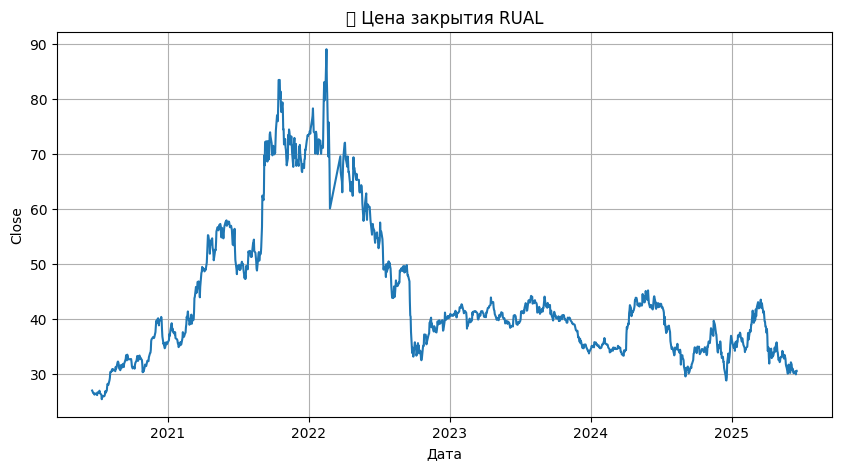


🤖 2. Инициализация УМЕНЬШЕННОЙ улучшенной модели...

✅ Total parameters: 1,597,564
✅ Trainable parameters: 1,597,564
✅ Model size: ~6.1 MB (float32)
✅ Device: cuda
💡 Примечание: Модель содержит 1.6M параметров.

📊 3. Подготовка данных для обучения (с исправленным скейлингом)... 

📦 Creating datasets for 19 tickers...


Processing Tickers: 100%|██████████| 19/19 [00:00<00:00, 29.36it/s]



📊 Total combined:
  Train samples: 25,074
  Val samples: 1,163
✅ DataLoaders ready (batch_size=32)

🎯 4. Обучение модели...



Epoch [  1/15] | Train Loss: 1.514343 | Val Loss: 1.060018 | Avg DA: 0.5058


Epoch [  2/15] | Train Loss: 1.344664 | Val Loss: 1.446865 | Avg DA: 0.3002


Epoch [  3/15] | Train Loss: 1.195237 | Val Loss: 1.528513 | Avg DA: 0.3252


Epoch [  4/15] | Train Loss: 1.074686 | Val Loss: 1.663264 | Avg DA: 0.3111


Epoch [  5/15] | Train Loss: 0.980396 | Val Loss: 1.688329 | Avg DA: 0.3058


Epoch [  6/15] | Train Loss: 0.896590 | Val Loss: 2.564065 | Avg DA: 0.3064

⚠️ Early stopping triggered after 6 epochs

✅ Training completed! Best validation loss: 1.060018

📈 5. Пример предсказания для тикера GAZP (обученная модель)...

Предсказания доходности на 20 дней для GAZP:
  День  1: return=+0.0007 (+0.07%), prob_up=0.391
  День  2: return=+0.0011 (+0.11%), prob_up=0.454
  День  3: return=+0.0018 (+0.18%), prob_up=0.520
  День  4: return=+0.0035 (+0.35%), prob_up=0.541
  День  5: return=+0.0016 (+0.16%), prob_up=0.538
  День  6: return=+0.0045 (+0.45%), prob_up=0.542
  День  7: return=+0.0044 (+0.44%), prob_up=0.542
  День  8: return=+0.0033 (+0.33%), prob_up=0.548
  День  9: return=+0.0046 (+0.46%), prob_up=0.551
  День 10: return=+0.0048 (+0.48%), prob_up=0.538
  День 11: return=+0.0057 (+0.57%), prob_up=0.545
  День 12: return=+0.0072 (+0.72%), prob_up=0.555
  День 13: return=+0.0077 (+0.77%), prob_up=0.555
  День 14: return=+0.0082 (+0.82%), prob_up=0.560
  День 15: retur

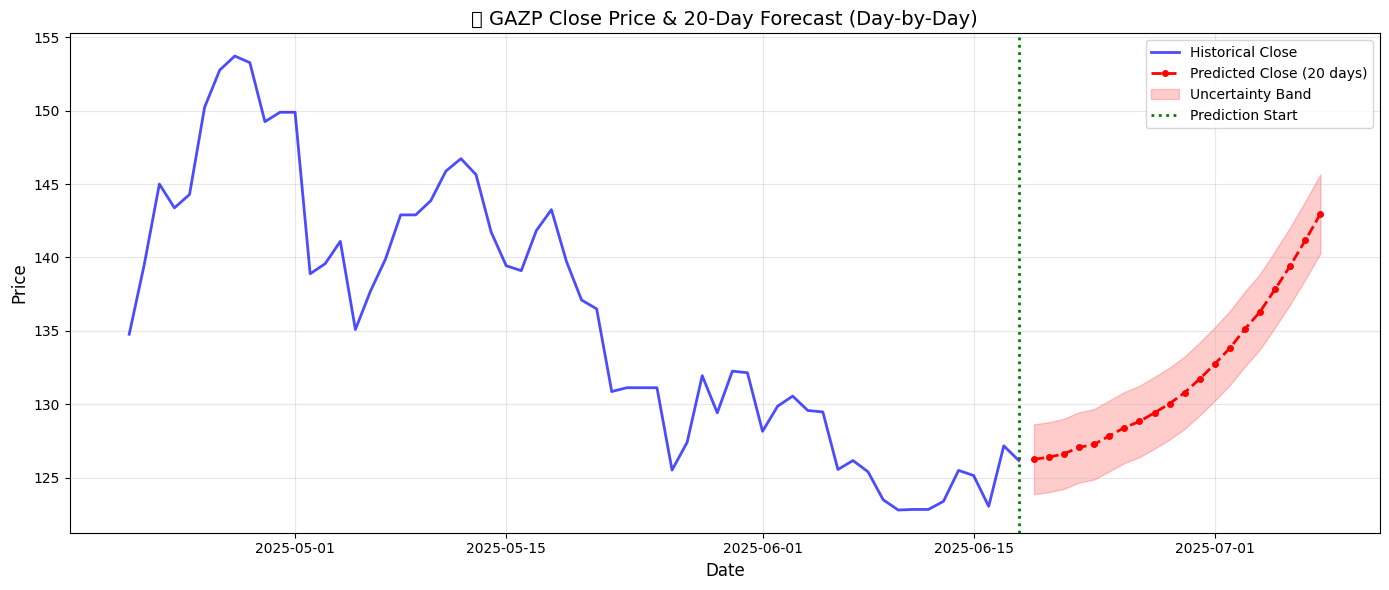

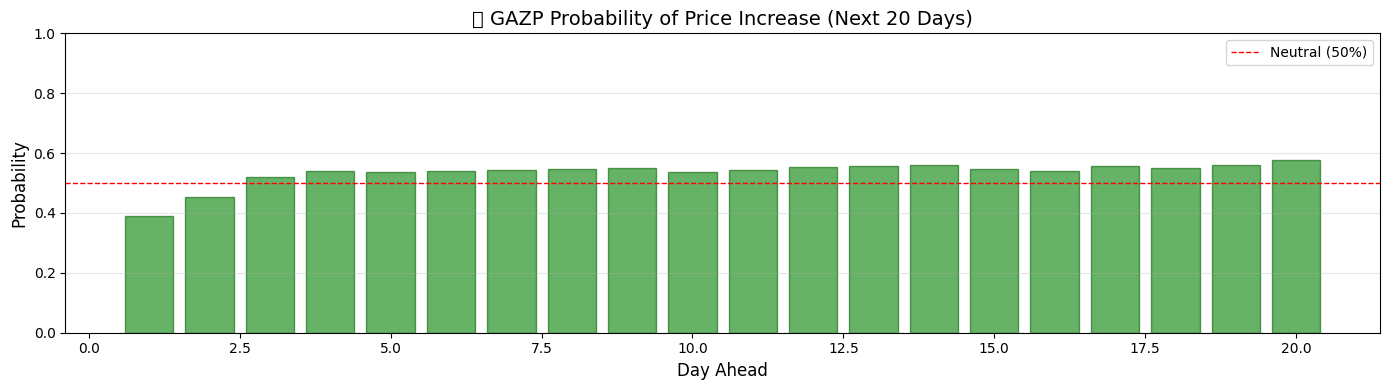


🎯 6. Генерация предсказаний для всех тикеров и Submission...



Generating Predictions: 100%|██████████| 19/19 [00:00<00:00, 49.99it/s]



📊 Predictions generated:
  Total rows: 380

Sample predictions:
   ticker  day    return   prob_up
0    AFLT    1  0.000679  0.389680
1    AFLT    2  0.001450  0.453061
2    AFLT    3  0.002307  0.523093
3    AFLT    4  0.004133  0.545470
4    AFLT    5  0.002036  0.542228
5    AFLT    6  0.005277  0.547656
6    AFLT    7  0.005205  0.551236
7    AFLT    8  0.004206  0.555033
8    AFLT    9  0.005376  0.558113
9    AFLT   10  0.006067  0.544990
10   AFLT   11  0.007037  0.553626
11   AFLT   12  0.008913  0.562047
12   AFLT   13  0.009547  0.565308
13   AFLT   14  0.010022  0.568869
14   AFLT   15  0.011690  0.558127
15   AFLT   16  0.011140  0.551352
16   AFLT   17  0.013621  0.568218
17   AFLT   18  0.014023  0.559806
18   AFLT   19  0.015206  0.571462
19   AFLT   20  0.015751  0.588608

Submission preview:
  ticker      r_t1     R_t20     pi_up
0   AFLT  0.000679  0.165193  0.389680
1   ALRS  0.000453  0.207632  0.379995
2   CHMF  0.000135  0.209259  0.381175
3   GAZP  0.000680  0.1

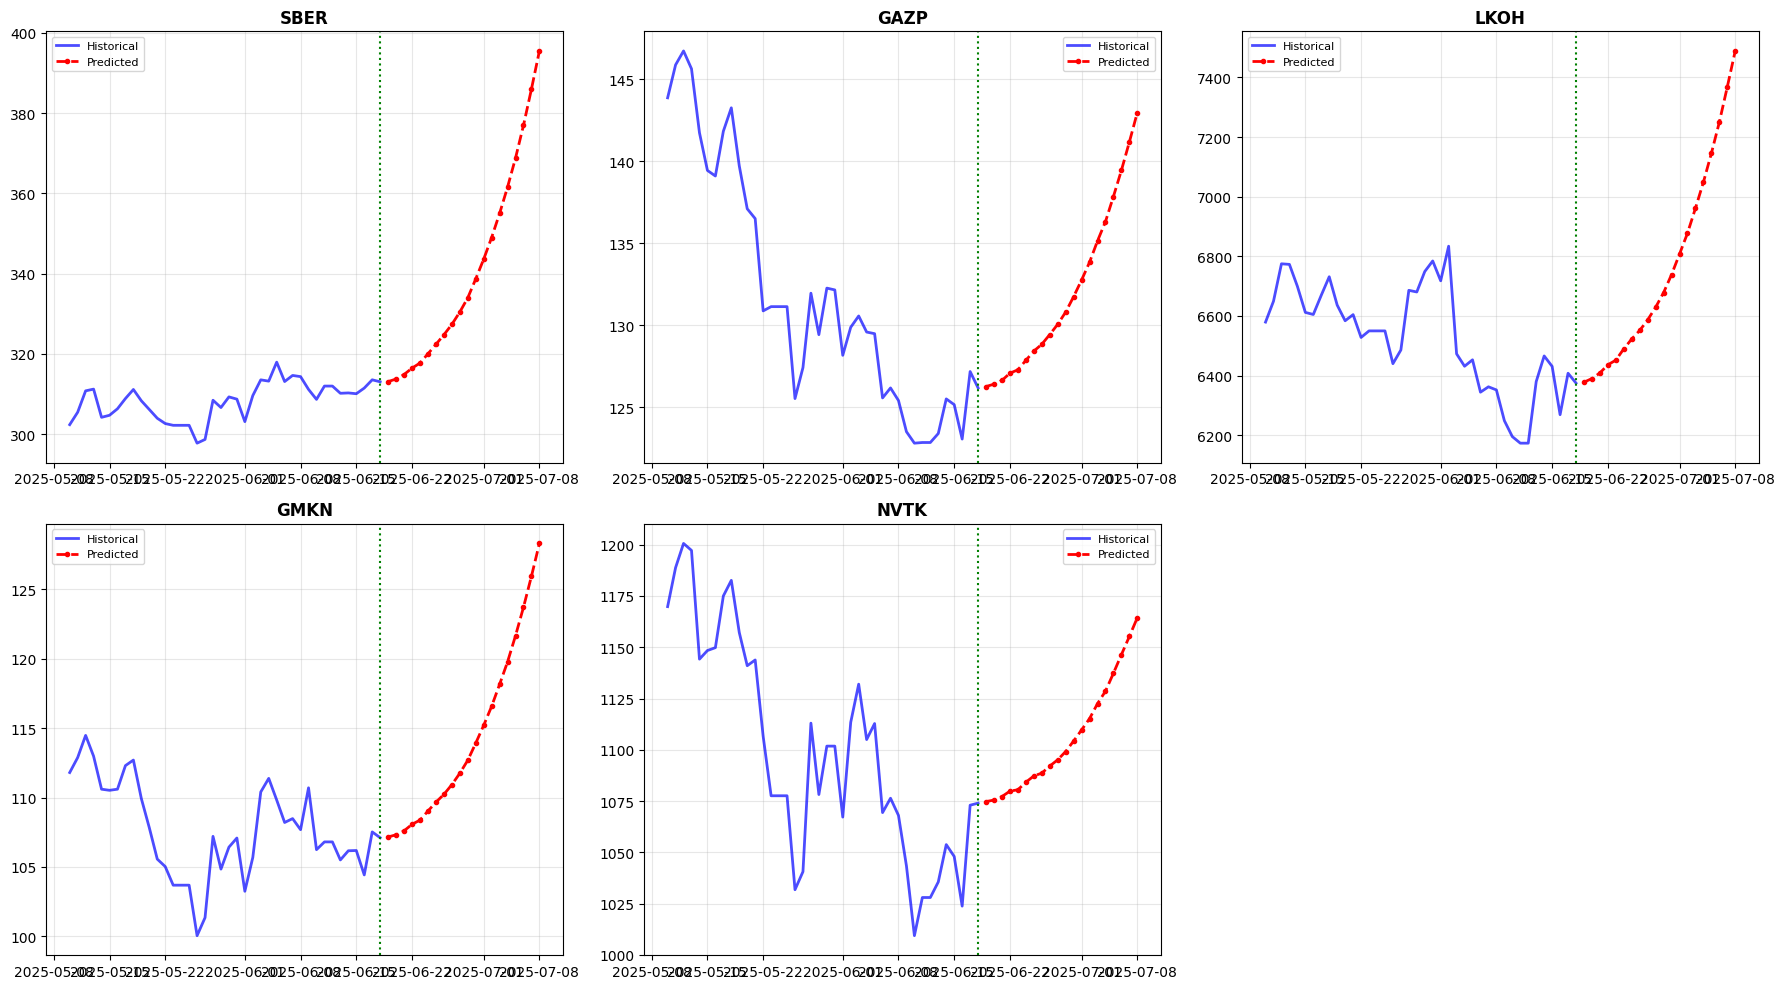

✅ Visualization of top-5 predictions completed.

📊 8. Расчет метрик на валидационном сете (с денормализацией)...



Calculating Metrics: 100%|██████████| 37/37 [00:02<00:00, 14.61it/s]


Метрики по дням:
 day      MAE    Brier       DA
   1 0.011034 0.213767 0.411006
   2 0.015371 0.234222 0.507309
   3 0.019345 0.249419 0.507309
   4 0.023001 0.251000 0.501290
   5 0.025581 0.251832 0.505589
   6 0.029493 0.250707 0.498710
   7 0.032413 0.249089 0.509028
   8 0.035193 0.250279 0.512468
   9 0.037399 0.250665 0.510748
  10 0.038918 0.252469 0.531384
  11 0.040961 0.254346 0.509888
  12 0.042212 0.253856 0.536543
  13 0.044120 0.251084 0.539123
  14 0.045802 0.253449 0.542562
  15 0.048117 0.247401 0.527945
  16 0.050160 0.243301 0.539983
  17 0.053881 0.252496 0.513328
  18 0.056272 0.248748 0.517627
  19 0.058093 0.252559 0.530525
  20 0.060880 0.259570 0.514187

📊 Средние метрики по горизонту (20 дней):
  MAE (Mean Absolute Error): 0.038412
  Brier Score: 0.248513
  DA (Directional Accuracy): 0.5133 (51.33%)


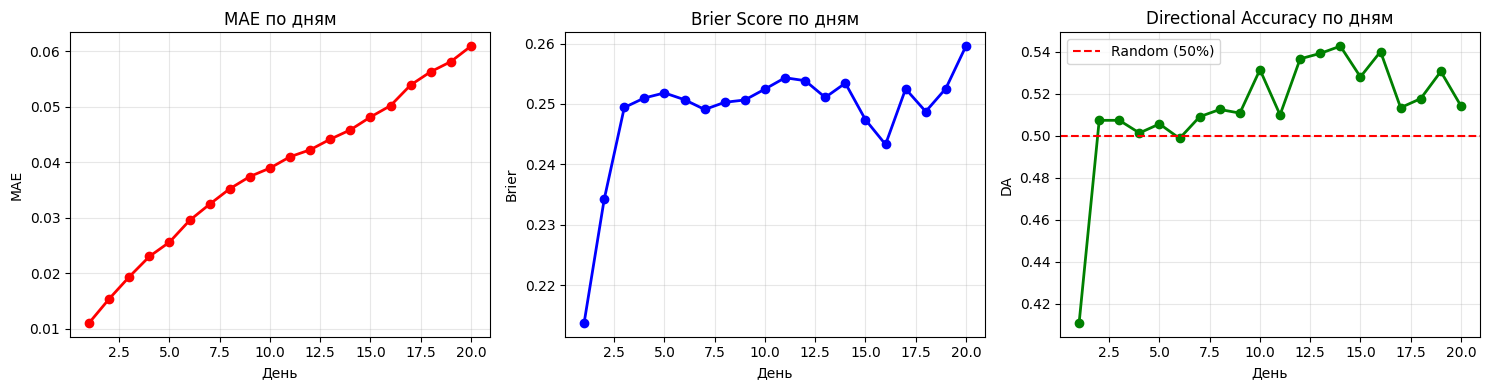


✅ Metrics visualization completed.


In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import warnings
import os
from tqdm import tqdm
import torch.nn.functional as F

warnings.filterwarnings('ignore')
SEED = 42
CANDLES_PATH = "/kaggle/input/finam-hackathon/candles.csv"
NEWS_PATH = "/kaggle/input/finam-hackathon/news.csv"

INPUT_WINDOW = 60
PRED_HORIZON = 20

np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("\n🔍 1. EDA: Исследование данных...\n")

candles = pd.read_csv(CANDLES_PATH)
news = pd.read_csv(NEWS_PATH)
candles["begin"] = pd.to_datetime(candles["begin"])
news["publish_date"] = pd.to_datetime(news["publish_date"])
if 'candles' in locals():
    print("🧾 Candles head:")
    print(candles.head(), "\n")
    print(f"📊 Тикеров: {candles['ticker'].nunique()}")
    print(f"📅 Период: {candles['begin'].min()} → {candles['begin'].max()}")

    ticker = candles["ticker"].sample(1, random_state=SEED).iloc[0]
    df_t = candles[candles["ticker"] == ticker].sort_values("begin")
    plt.figure(figsize=(10, 5))
    plt.plot(df_t["begin"], df_t["close"])
    plt.title(f"📈 Цена закрытия {ticker}")
    plt.xlabel("Дата")
    plt.ylabel("Close")
    plt.grid(True)
    plt.show()

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        self.layers = nn.ModuleList()
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]

            conv = nn.Conv1d(
                in_channels, out_channels, kernel_size,
                padding='same', dilation=dilation_size
            )
            self.layers.append(nn.Sequential(
                conv,
                nn.BatchNorm1d(out_channels),
                nn.ReLU(),
                nn.Dropout(dropout)
            ))      
        self.output_channels = num_channels[-1]
        
    def forward(self, x):
        x = x.transpose(1, 2)  # [batch, features, seq_len]
        
        for layer in self.layers:
            x = layer(x)
        
        return x.transpose(1, 2)  # [batch, seq_len, features]

class ImprovedForecastModel(nn.Module):
    def __init__(self, input_dim=11, hidden_dim=128, num_layers=4, 
                  num_heads=8, dropout=0.2, pred_horizon=20):
        super().__init__()
        
        self.pred_horizon = pred_horizon
        self.hidden_dim = hidden_dim 
        self.feature_proj = nn.Linear(input_dim, hidden_dim)
        self.pos_encoder = PositionalEncoding(hidden_dim)
        self.tcn = TemporalConvNet(
            hidden_dim, 
            [hidden_dim, hidden_dim, hidden_dim], 
            kernel_size=7,
            dropout=dropout
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
.
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        self.final_repr_proj = nn.Linear(3 * hidden_dim, hidden_dim) 

        self.return_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim // 2, 1)
            ) for _ in range(pred_horizon)
        ])     
        self.prob_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim // 2, 1),
                nn.Sigmoid()
            ) for _ in range(pred_horizon)
        ])
        self.global_return_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, pred_horizon)
        )
        
    def forward(self, x):

        x = self.feature_proj(x)
        x = self.pos_encoder(x)
        tcn_out = self.tcn(x)
        trans_out = self.transformer(x)

        combined = tcn_out + trans_out
        attn_out, _ = self.attention(combined, combined, combined) 

        last_state = attn_out[:, -1, :]
        avg_state = attn_out.mean(dim=1) 
        max_state = attn_out.max(dim=1)[0]       
        pooled = torch.cat([last_state, avg_state, max_state], dim=-1) # [batch, 3*hidden_dim]
        final_repr = self.final_repr_proj(pooled) # [batch, hidden_dim]

        daily_returns = []
        daily_probs = []        
        for i in range(self.pred_horizon):
            daily_returns.append(self.return_heads[i](final_repr))
            daily_probs.append(self.prob_heads[i](final_repr))
        
        daily_returns = torch.cat(daily_returns, dim=1)  # [batch, pred_horizon]
        daily_probs = torch.cat(daily_probs, dim=1)

        global_returns = self.global_return_head(final_repr)  # [batch, pred_horizon]

        final_returns = 0.7 * daily_returns + 0.3 * global_returns    
        return final_returns, daily_probs

class ImprovedTimeSeriesDataset(Dataset):
    def __init__(self, df, seq_len=60, pred_horizon=20, feature_scaler=None, return_scaler=None):
        self.seq_len = seq_len
        self.pred_horizon = pred_horizon
        df = df.groupby("begin").agg({
            "open": "first",
            "high": "max",
            "low": "min",
            "close": "last",
            "volume": "sum"
        }).reset_index()
        df = df.set_index("begin").asfreq("D").ffill()     
        self.features = self._create_features(df)
        self.targets = self._create_targets(df)
        self.close_prices = df['close'].values
        if feature_scaler is None:
            self.feature_scaler = RobustScaler()
            self.features = self.feature_scaler.fit_transform(self.features)
        else:
            self.feature_scaler = feature_scaler
            self.features = self.feature_scaler.transform(self.features)

        returns_flat = self.targets['returns'].flatten().reshape(-1, 1) # [N * 20, 1]
        
        if return_scaler is None:
            self.return_scaler = RobustScaler() 
            returns_scaled_flat = self.return_scaler.fit_transform(returns_flat)
        else:
            self.return_scaler = return_scaler
            returns_scaled_flat = self.return_scaler.transform(returns_flat)            
        self.targets['returns'] = returns_scaled_flat.reshape(self.targets['returns'].shape)        
        self.valid_indices = self._get_valid_indices()  
    def _create_features(self, df):
        features = []
        features.append(np.log(df['open']).values)
        features.append(np.log(df['high']).values)
        features.append(np.log(df['low']).values)
        features.append(np.log(df['close']).values)
        features.append(np.log(df['volume'] + 1).values)
        features.append(np.log(df['close'] / df['close'].shift(1)).fillna(0).values)
        returns = np.log(df['close'] / df['close'].shift(1))
        features.append(returns.rolling(20).std().fillna(0).values)

        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        features.append(rsi.fillna(50).values / 100.0) # normalize to [0, 1]

        ma5 = df['close'].rolling(5).mean()
        ma20 = df['close'].rolling(20).mean()
        features.append((ma5 / ma20 - 1).fillna(0).values) # normalized difference
        features.append((df['volume'] / df['volume'].shift(1) - 1).fillna(0).values)
        features.append(((df['high'] - df['low']) / df['close']).values)
        
        return np.column_stack(features)
    
    def _create_targets(self, df):
        returns = []
        directions = []        
        for h in range(1, self.pred_horizon + 1):
            # Простая доходность: (P_t+h / P_t) - 1
            ret = (df['close'].shift(-h) / df['close'] - 1).values
            returns.append(ret)
            # Направление: 1.0 если возврат > 0, иначе 0.0
            directions.append((ret > 0).astype(float))
        
        return {
            'returns': np.column_stack(returns),      # [N, pred_horizon]
            'directions': np.column_stack(directions) # [N, pred_horizon]
        }

    def _get_valid_indices(self):
        """Индексы где есть все данные"""
        valid = []
        for i in range(self.seq_len, len(self.features) - self.pred_horizon):
            if (not np.isnan(self.features[i-self.seq_len:i]).any() and
                not np.isnan(self.targets['returns'][i]).any()):
                valid.append(i)
        return valid
    
    def __len__(self):
        return len(self.valid_indices)    
    
    def __getitem__(self, idx):
        i = self.valid_indices[idx]
        X = torch.FloatTensor(self.features[i-self.seq_len:i])
        y_returns = torch.FloatTensor(self.targets['returns'][i])
        y_directions = torch.FloatTensor(self.targets['directions'][i])        
        return X, y_returns, y_directions

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.2, gamma=0.1): 
        super().__init__()
        self.alpha = alpha  
        self.beta = beta    
        self.gamma = gamma  
        self.mse = nn.MSELoss()
        self.bce = nn.BCELoss()    
        
    def forward(self, pred_returns, pred_probs, true_returns, true_directions):
        loss_mse = self.mse(pred_returns, true_returns)
        loss_bce = self.bce(pred_probs, true_directions)
        pred_directions = (pred_returns > 0).float()
        loss_dir = 1.0 - (pred_directions == true_directions).float().mean() # 1 - DA
        
        return self.alpha * loss_mse + self.beta * loss_bce + self.gamma * loss_dir

def train_model(model, train_loader, val_loader, epochs=50, lr=1e-4, patience=10):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    criterion = CombinedLoss()
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_batches = 0        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for X, y_returns, y_directions in pbar:
            X = X.to(device)
            y_returns = y_returns.to(device)
            y_directions = y_directions.to(device)            
            optimizer.zero_grad()
            pred_returns, pred_probs = model(X)
            loss = criterion(pred_returns, pred_probs, y_returns, y_directions)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()   
            train_loss += loss.item()
            train_batches += 1
            pbar.set_postfix(loss=train_loss/train_batches)
            
        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss = 0.0
        val_batches = 0        
        all_pred_returns = []
        all_true_returns = []
        all_pred_probs = []
        all_true_directions = []
        
        with torch.no_grad():
            for X, y_returns, y_directions in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]  ", leave=False):
                X = X.to(device)
                y_returns = y_returns.to(device)
                y_directions = y_directions.to(device)
                
                pred_returns, pred_probs = model(X)
                loss = criterion(pred_returns, pred_probs, y_returns, y_directions)
                val_loss += loss.item()
                val_batches += 1
                all_pred_returns.append(pred_returns.cpu())
                all_true_returns.append(y_returns.cpu())
                all_pred_probs.append(pred_probs.cpu())
                all_true_directions.append(y_directions.cpu())
        avg_val_loss = val_loss / val_batches
        val_losses.append(avg_val_loss)
        all_pred_returns_tensor = torch.cat(all_pred_returns)
        all_true_directions_tensor = torch.cat(all_true_directions)
        val_da = np.mean((all_pred_returns_tensor.numpy() > 0) == all_true_directions_tensor.numpy())
        
        scheduler.step(avg_val_loss)
        
        print(f"Epoch [{epoch+1:3d}/{epochs}] | "
              f"Train Loss: {avg_train_loss:.6f} | "
              f"Val Loss: {avg_val_loss:.6f} | "
              f"Avg DA: {val_da:.4f}") 
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n⚠️ Early stopping triggered after {epoch+1} epochs")
                break
    model.load_state_dict(torch.load('best_model.pth'))
    print(f"\n✅ Training completed! Best validation loss: {best_val_loss:.6f}")  
    return train_losses, val_losses
def predict_future(model, df_t, seq_len=60, pred_horizon=20, feature_scaler=None, return_scaler=None):
    if feature_scaler is None or return_scaler is None:
        raise ValueError("Scaler models must be provided for prediction.") 
    model.eval()
    df_prep = df_t.groupby("begin").agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum"
    }).reset_index()   
    df_prep = df_prep.set_index("begin").asfreq("D").ffill()   
    features = []
    features.append(np.log(df_prep['open']).values)
    features.append(np.log(df_prep['high']).values)
    features.append(np.log(df_prep['low']).values)
    features.append(np.log(df_prep['close']).values)
    features.append(np.log(df_prep['volume'] + 1).values)
    log_returns = np.log(df_prep['close'] / df_prep['close'].shift(1)).fillna(0)
    features.append(log_returns.values)
    features.append(log_returns.rolling(20).std().fillna(0).values)

    delta = df_prep['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    features.append(rsi.fillna(50).values / 100.0)
    ma5 = df_prep['close'].rolling(5).mean()
    ma20 = df_prep['close'].rolling(20).mean()
    features.append((ma5 / ma20 - 1).fillna(0).values)
    features.append((df_prep['volume'] / df_prep['volume'].shift(1) - 1).fillna(0).values)
    features.append(((df_prep['high'] - df_prep['low']) / df_prep['close']).values)
    features = np.column_stack(features)
    features = feature_scaler.transform(features)
    if len(features) < seq_len:
        padding = np.zeros((seq_len - len(features), features.shape[1]))
        features = np.vstack((padding, features))    
    last_seq = torch.FloatTensor(features[-seq_len:]).unsqueeze(0).to(device)  
    with torch.no_grad():
        daily_returns_scaled, daily_probs = model(last_seq)
    preds_scaled = daily_returns_scaled.cpu().numpy()[0].reshape(pred_horizon, 1) # shape: [20, 1]
    preds = return_scaler.inverse_transform(preds_scaled).flatten() # shape: [20]
    probs = daily_probs.cpu().numpy()[0]  # shape: [20]   
    return preds, probs
from sklearn.metrics import mean_absolute_error, brier_score_loss
def calculate_metrics(model, val_loader, device, return_scaler):
    model.eval()
    all_pred_returns = []
    all_true_returns = []
    all_pred_probs = []
    all_true_directions = []
    with torch.no_grad():
        for X, y_returns_scaled, y_directions in tqdm(val_loader, desc="Calculating Metrics"):
            X = X.to(device)
            pred_returns_scaled, pred_probs = model(X)
            N_batch = y_returns_scaled.shape[0]
            pred_flat = pred_returns_scaled.cpu().numpy().flatten().reshape(-1, 1)
            pred_returns = return_scaler.inverse_transform(pred_flat).reshape(N_batch, PRED_HORIZON)
            
            # Денормализуем таргеты
            true_flat = y_returns_scaled.cpu().numpy().flatten().reshape(-1, 1)
            true_returns = return_scaler.inverse_transform(true_flat).reshape(N_batch, PRED_HORIZON)
            
            all_pred_returns.append(pred_returns)
            all_true_returns.append(true_returns)
            all_pred_probs.append(pred_probs.cpu().numpy())
            all_true_directions.append(y_directions.cpu().numpy())

    pred_returns_all = np.concatenate(all_pred_returns)
    true_returns_all = np.concatenate(all_true_returns)
    pred_probs_all = np.concatenate(all_pred_probs)
    true_directions_all = np.concatenate(all_true_directions)
    
    metrics = []
    for day in range(PRED_HORIZON):
        mae = mean_absolute_error(true_returns_all[:, day], pred_returns_all[:, day])
        # Для Brier Score используются предсказанные вероятности
        brier = brier_score_loss(true_directions_all[:, day], pred_probs_all[:, day]) 
        # Для DA используются предсказанные возвраты (знак)
        pred_directions = (pred_returns_all[:, day] > 0).astype(int)
        da = np.mean(pred_directions == true_directions_all[:, day])
        
        metrics.append({
            'day': day + 1,
            'MAE': mae,
            'Brier': brier,
            'DA': da
        })       
    return pd.DataFrame(metrics)
def generate_predictions_for_all_tickers(model, candles_df, seq_len=60, pred_horizon=20, feature_scaler=None, return_scaler=None):
    if feature_scaler is None or return_scaler is None:
        raise ValueError("Scaler models must be provided for prediction.")   
    unique_tickers = candles_df['ticker'].unique()
    all_predictions = []
    for ticker in tqdm(unique_tickers, desc="Generating Predictions"):
        df_t = candles_df[candles_df['ticker'] == ticker].copy()
        if len(df_t) < seq_len:
            continue  
        try:
            preds, probs = predict_future(
                model, 
                df_t, 
                seq_len=seq_len, 
                pred_horizon=pred_horizon,
                feature_scaler=feature_scaler,
                return_scaler=return_scaler
            )
            
            for day in range(pred_horizon):
                all_predictions.append({
                    'ticker': ticker,
                    'day': day + 1,
                    'return': preds[day],
                    'prob_up': probs[day]
                })
        except Exception as e:
            continue

    return pd.DataFrame(all_predictions)

INPUT_DIM = 11
HIDDEN_DIM = 128  # Уменьшено (было 256)
NUM_LAYERS = 4    # Уменьшено (было 8)
NUM_HEADS = 8     # Уменьшено (было 16)

model = ImprovedForecastModel(
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    dropout=0.2,
    pred_horizon=PRED_HORIZON
).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"✅ Total parameters: {total_params:,}")
print(f"✅ Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"✅ Model size: ~{total_params * 4 / (1024**2):.1f} MB (float32)")
print(f"✅ Device: {device}")

print("\n📊 3. Подготовка данных для обучения (с исправленным скейлингом)... \n")

TRAIN_CUTOFF = pd.Timestamp('2024-09-08')

train_candles = candles[candles['begin'] <= TRAIN_CUTOFF].copy()
test_candles = candles[candles['begin'] > TRAIN_CUTOFF].copy()

all_train_datasets = []
all_val_datasets = []

unique_tickers = train_candles['ticker'].unique()
print(f"📦 Creating datasets for {len(unique_tickers)} tickers...")

first_ticker_data = train_candles[train_candles['ticker'] == unique_tickers[0]].copy()
initial_ds = ImprovedTimeSeriesDataset(first_ticker_data, seq_len=INPUT_WINDOW, pred_horizon=PRED_HORIZON)
global_feature_scaler = initial_ds.feature_scaler
global_return_scaler = initial_ds.return_scaler

for ticker in tqdm(unique_tickers, desc="Processing Tickers"):
    ticker_data = train_candles[train_candles['ticker'] == ticker].copy()
    
    if len(ticker_data) < INPUT_WINDOW + PRED_HORIZON + 150: 
        continue
    ticker_data_sorted = ticker_data.sort_values('begin')
    if len(ticker_data_sorted) > 100:
        val_split_date = ticker_data_sorted['begin'].iloc[-100] # Дата начала последних 100 дней
    else:
        continue

    train_subset = ticker_data_sorted[ticker_data_sorted['begin'] < val_split_date]
    val_subset = ticker_data_sorted[ticker_data_sorted['begin'] >= val_split_date]

    try:
        train_ds = ImprovedTimeSeriesDataset(
            train_subset, 
            seq_len=INPUT_WINDOW, 
            pred_horizon=PRED_HORIZON,
            feature_scaler=global_feature_scaler,
            return_scaler=global_return_scaler
        )
        val_ds = ImprovedTimeSeriesDataset(
            val_subset, 
            seq_len=INPUT_WINDOW, 
            pred_horizon=PRED_HORIZON,
            feature_scaler=global_feature_scaler,
            return_scaler=global_return_scaler
        )
        
        if len(train_ds) > 0 and len(val_ds) > 0:
            all_train_datasets.append(train_ds)
            all_val_datasets.append(val_ds)
    except Exception as e:
        # print(f"Error creating dataset for {ticker}: {e}") # Отключаем для чистоты вывода
        pass 

train_dataset = ConcatDataset(all_train_datasets)
val_dataset = ConcatDataset(all_val_datasets)

print(f"\n📊 Total combined:")
print(f"  Train samples: {len(train_dataset):,}")
print(f"  Val samples: {len(val_dataset):,}")

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✅ DataLoaders ready (batch_size={BATCH_SIZE})")

print("\n🎯 4. Обучение модели...\n")
train_losses, val_losses = train_model(
    model, 
    train_loader, 
    val_loader, 
    epochs=15, 
    lr=1e-4,
    patience=5 
)


print("\n📈 5. Пример предсказания для тикера GAZP (обученная модель)...\n")

ticker_plot = "GAZP"
df_t = candles[candles["ticker"] == ticker_plot].copy()

preds, probs = predict_future(
    model, 
    df_t, 
    seq_len=INPUT_WINDOW, 
    pred_horizon=20,
    feature_scaler=global_feature_scaler,
    return_scaler=global_return_scaler
)

print(f"Предсказания доходности на 20 дней для {ticker_plot}:")
for i, (p, prob) in enumerate(zip(preds, probs), 1):
    print(f"  День {i:2d}: return={p:+.4f} ({p*100:+.2f}%), prob_up={prob:.3f}")
df_plot = df_t.groupby("begin").agg({
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum"
}).reset_index()
df_plot = df_plot.set_index("begin").asfreq("D")
df_plot.ffill(inplace=True)
last_date = df_plot.index[-1]
pred_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=20)
last_price = df_plot["close"][-1]
pred_prices = [last_price]
for ret in preds:
    pred_prices.append(pred_prices[-1] * (1 + ret))
pred_prices = np.array(pred_prices[1:])

plt.figure(figsize=(14, 6))
plt.plot(df_plot.index[-60:], df_plot["close"][-60:], 
             label="Historical Close", linewidth=2, color='blue', alpha=0.7)
plt.plot(pred_dates, pred_prices, 
             label="Predicted Close (20 days)", 
             linestyle="--", linewidth=2, marker='o', markersize=4, color='red')
uncertainty = np.std(preds) * pred_prices * 5 # Увеличенный коэффициент для визуализации
plt.fill_between(pred_dates, 
                 pred_prices - uncertainty, 
                 pred_prices + uncertainty,
                 alpha=0.2, color='red', label='Uncertainty Band')

plt.axvline(x=last_date, color='green', linestyle=':', linewidth=2, label='Prediction Start')
plt.title(f"📈 {ticker_plot} Close Price & 20-Day Forecast (Day-by-Day)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 4))
plt.bar(range(1, 21), probs, color='green', alpha=0.6, edgecolor='darkgreen')
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1, label='Neutral (50%)')
plt.title(f"📊 {ticker_plot} Probability of Price Increase (Next 20 Days)", fontsize=14)
plt.xlabel("Day Ahead", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.ylim(0, 1)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

predictions_df = generate_predictions_for_all_tickers(
    model, 
    candles, 
    seq_len=INPUT_WINDOW, 
    pred_horizon=PRED_HORIZON,
    feature_scaler=global_feature_scaler,
    return_scaler=global_return_scaler
)

print(f"\n📊 Predictions generated:")
print(f"  Total rows: {len(predictions_df):,}")
print("\nSample predictions:")
print(predictions_df.head(20))

submission_rows = []

for ticker in predictions_df['ticker'].unique():
    ticker_preds = predictions_df[predictions_df['ticker'] == ticker].sort_values('day')
    
    if len(ticker_preds) >= 20:
        r_t1 = ticker_preds[ticker_preds['day'] == 1]['return'].values[0]
        returns_20 = ticker_preds['return'].values[:20]
        R_t20 = np.prod(1 + returns_20) - 1 
        pi_up = ticker_preds[ticker_preds['day'] == 1]['prob_up'].values[0]
        
        submission_rows.append({
            'ticker': ticker,
            'r_t1': r_t1,
            'R_t20': R_t20,
            'pi_up': pi_up
        })

submission_df = pd.DataFrame(submission_rows)

print("\nSubmission preview:")
print(submission_df.head(10))
print(f"\n💾 Submission file generated (Tickers: {len(submission_df)})")

print("\n📊 7. Визуализация предсказаний для топ-5 тикеров...\n")

top_tickers = ['SBER', 'GAZP', 'LKOH', 'GMKN', 'NVTK']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, ticker in enumerate(top_tickers):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    df_t = candles[candles['ticker'] == ticker].copy()
    
    if len(df_t) < INPUT_WINDOW:
        ax.set_title(f"{ticker} - Not enough data")
        continue

    try:
        preds, probs = predict_future(
            model, 
            df_t, 
            seq_len=INPUT_WINDOW, 
            pred_horizon=PRED_HORIZON,
            feature_scaler=global_feature_scaler,
            return_scaler=global_return_scaler
        )
    except Exception as e:
        ax.set_title(f"{ticker} - Prediction Error: {e}")
        continue
        
    df_plot = df_t.groupby("begin").agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum"
    }).reset_index()
    df_plot = df_plot.set_index("begin").asfreq("D").ffill()
    last_date = df_plot.index[-1]
    pred_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=20)
    last_price = df_plot["close"][-1]
    
    pred_prices = [last_price]
    for ret in preds:
        pred_prices.append(pred_prices[-1] * (1 + ret))
    pred_prices = np.array(pred_prices[1:])

    ax.plot(df_plot.index[-40:], df_plot["close"][-40:], 
              label="Historical", linewidth=2, color='blue', alpha=0.7)
    ax.plot(pred_dates, pred_prices, 
              label="Predicted", linestyle="--", linewidth=2, marker='o', 
              markersize=3, color='red')
    ax.axvline(x=last_date, color='green', linestyle=':', linewidth=1.5)
    ax.set_title(f"{ticker}", fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
if len(axes) > len(top_tickers):
    axes[len(top_tickers)].axis('off')

plt.tight_layout()
plt.show()

metrics_df = calculate_metrics(model, val_loader, device, global_return_scaler)

print("Метрики по дням:")
print(metrics_df.to_string(index=False))

print(f"\n📊 Средние метрики по горизонту (20 дней):")
print(f"  MAE (Mean Absolute Error): {metrics_df['MAE'].mean():.6f}")
print(f"  Brier Score: {metrics_df['Brier'].mean():.6f}")
print(f"  DA (Directional Accuracy): {metrics_df['DA'].mean():.4f} ({metrics_df['DA'].mean()*100:.2f}%)")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(metrics_df['day'], metrics_df['MAE'], marker='o', linewidth=2, color='red')
axes[0].set_title('MAE по дням')
axes[0].set_xlabel('День')
axes[0].set_ylabel('MAE')
axes[0].grid(True, alpha=0.3)

axes[1].plot(metrics_df['day'], metrics_df['Brier'], marker='o', linewidth=2, color='blue')
axes[1].set_title('Brier Score по дням')
axes[1].set_xlabel('День')
axes[1].set_ylabel('Brier')
axes[1].grid(True, alpha=0.3)
axes[2].plot(metrics_df['day'], metrics_df['DA'], marker='o', linewidth=2, color='green')
axes[2].axhline(y=0.5, color='red', linestyle='--', label='Random (50%)')
axes[2].set_title('Directional Accuracy по дням')
axes[2].set_xlabel('День')
axes[2].set_ylabel('DA')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("\n✅ Metrics visualization completed.")



In [11]:
!pip install transliterate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.9 MB/s eta 0:00:00


In [ ]:
TICKER_KEYWORDS = {
    "GAZP": ["Газпром", "Gazprom", "ГАЗП", "Gazprom Neft"],
    "SBER": ["Сбербанк", "Sberbank", "СБЕР", "Сбер"],
    "SBERP": ["Сбербанк-п", "Sberbank-p", "СБЕР-п"],
    "LKOH": ["Лукойл", "Lukoil", "ЛУКОЙЛ"],
    "GMKN": ["Норникель", "Nornickel", "ГМК"],
    "YNDX": ["Яндекс", "Yandex", "YNDX"],
    "VTBR": ["ВТБ", "VTB", "ВТБ Банк"],
    "ROSN": ["Роснефть", "Rosneft", "РОСНЕФТЬ"],
    "NVTK": ["НОВАТЭК", "Novatek"],
    "SIBN": ["Газпром нефть", "Gazprom Neft", "ГАЗПРОМ НЕФТЬ"],
    "PHOR": ["ФосАгро", "PhosAgro", "ФОСАГРО"],
    "PLZL": ["Полюс Золото", "Polyus", "ПОЛЮС"],
    "MTSS": ["МТС", "MTS", "МТС Банк"],
    "MGNT": ["Магнит", "Magnit", "МАГНИТ"],
    "CHMF": ["Северсталь", "Severstal", "СЕВЕРСТАЛЬ"],
    "NLMK": ["НЛМК", "NLMK", "Новолипецкий металлургический комбинат"],
    "ALRS": ["АЛРОСА", "Alrosa"],
    "RUAL": ["РУСАЛ", "Rusal"],
    "AFKS": ["АФК Система", "AFK Sistema", "СИСТЕМА"],
    "MOEX": ["Московская биржа", "MOEX", "БИРЖА"],
    "HYDR": ["РусГидро", "RusHydro", "РУСГИДРО"],
    "IRAO": ["Интер РАО", "Inter RAO", "ИНТЕР РАО"],
    "AFLT": ["Аэрофлот", "Aeroflot", "АЭРОФЛОТ"],

    "SNGS": ["Сургутнефтегаз", "Surgutneftegas", "СНГ"],
    "SNGSP": ["Сургутнефтегаз-п", "Surgutneftegas-p", "СНГ-п"],
    "TATN": ["Татнефть", "Tatneft", "ТАТНЕФТЬ"],
    "TATNP": ["Татнефть-п", "Tatneft-p", "ТАТНЕФТЬ-п"],
    "VTBRP": ["ВТБ-п", "VTB-p", "ВТБ Банк-п"],
    "MGNP": ["Магнит-п", "Magnit-p", "МАГНИТ-п"],
    "TRNFP": ["Транснефть", "Transneft", "ТРАНСНЕФТЬ"],
    "TRNF": ["Транснефть", "Transneft", "ТРАНСНЕФТЬ"],
    "URKA": ["Уралкалий", "Uralkali", "УРАЛКАЛИЙ"],
    "URKAP": ["Уралкалий-п", "Uralkali-p", "УРАЛКАЛИЙ-п"],
    "BANE": ["Башнефть", "Bashneft"],
    "FESH": ["ДВМП", "Дальневосточное морское пароходство", "FESCO"],
    "UWGN": ["ОВК", "Объединенная вагонная компания", "ОВК"],

    "T": ["Тинькофф Банк", "Tinkoff", "ТИНЬКОФФ", 'Т-Банк', 'Т'],
    "VKCO": ["VK Company", "VK", "ВКОНТАКТЕ"],
    "PIKK": ["ПИК-специализированный застройщик", "PIK", "ПИК"],
    "SMLT": ["Самолет", "Samolet", "САМОЛЕТ"],
    "POSI": ["Positive Technologies", "ПОЗИТИВ"],
    "FIVE": ["X5 Retail Group", "X5", "Х5"],
    "SVCB": ["Совкомбанк", "Sovcombank", "СОВКОМБАНК"],
    "SVCBP": ["Совкомбанк-п", "Sovcombank-p", "СОВКОМБАНК-п"],
    "CIAN": ["ЦИАН", "CIAN Group", "ЦИАН ГРУПП"],
    "HHRU": ["HeadHunter", "Хедхантер", "HH"],
    "DELI": ["Делимобиль", "Delimobil", "ДЕЛИМОБИЛЬ"], 
    "DIAS": ["Диасофт", "Diasoft", "DIASOFT"],
    "EVI": ["Европлан", "Europlan", "ЕВРОПЛАН"],
    "MTBC": ["МТС Банк", "MTS Bank", "МТС-БАНК"],
    "OZON": ["Озон", "Ozon Holdings", "OZON"], 
    "DATA": ["Аренадата", "Arenadata", "DATA"],
    "SPBE": ["СПБ Биржа", "SPB Exchange", "СПБ"],
    "CBOM": ["МКБ", "Moscow Credit Bank", "МОСКОВСКИЙ КРЕДИТНЫЙ БАНК"],
    "PRMB": ["Промсвязьбанк", "PSB", "ПСБ"],
    "ABIO": ["Астра", "ГК Астра", "Astra Group", "ASTRA"], 
    "SOFL": ["Софтлайн", "Softline", "СОФТЛАЙН"], 
    "DELPO": ["Депозитарный расписки", "Депозитарные расписки", "ГДР"],

    "RASP": ["Распадская", "Raspadskaya", "РАСПАДСКАЯ"],
    "POLY": ["Полиметалл", "Polymetal", "ПОЛИМЕТАЛЛ"],
    "RUALP": ["РУСАЛ-п", "Rusal-p"],
    "MAGN": ["ММК", "MMK", "Магнитогорский металлургический комбинат"],
    "MSNG": ["Мечел", "Mechel", "МЕЧЕЛ"],
    "TRMK": ["ТМК", "Трубная металлургическая компания", "TMK"], 
    "KMAZ": ["КАМАЗ", "KAMAZ", "КАМАЗ"],
    "VSMO": ["ВСМПО-Ависма", "VSMPO-AVISMA"], 
    "AKRN": ["Акрон", "Acron"],
    "KZOS": ["Казаньоргсинтез", "Kazanorgsintez", "КОС"],

    "GCHE": ["Группа Черкизово", "Cherkizovo Group", "ЧЕРКИЗОВО"],
    "RZSP": ["Русагро", "Rusagro", "РУСАГРО"],
    "RZSPP": ["Русагро-п", "Rusagro-p", "РУСАГРО-п"],
    "OKEY": ["О'КЕЙ", "O'KEY", "ОКЕЙ"],
    "APTK": ["Аптечная сеть 36,6", "APTEKA 36,6", "АПТЕКА"],
    "DIXY": ["Дикси Групп", "DIXY Group", "ДИКСИ"],
    "ABRD": ["Абрау-Дюрсо", "Abrau-Durso", "АБРАУ"],

    "MRKC": ["Россети Центр", "MRSK Center", "МРСК ЦЕНТРА"],
    "MRKU": ["Россети Урал", "MRSK Urala", "МРСК УРАЛА"],
    "MRKP": ["Россети Центр и Приволжье", "MRSK Center & Privolzhye", "МРСК ЦИП"],
    "MRKV": ["Россети Волга", "MRSK Volga", "МРСК ВОЛГА"],
    "MSRS": ["Россети Московский регион", "МОЭСК", "MSRS"],
    "MRKK": ["Россети Северный Кавказ", "MRK-SK", "РОССЕТИ СК"],
    "MRKY": ["Россети Юг", "MRK-Yug", "РОССЕТИ ЮГ"],
    "MRKZ": ["Россети Северо-Запад", "MRSK SZ", "МРСК СЗ"],
    "FEES": ["ФСК ЕЭС", "FSK EES", "ФСК"],
    "OGKB": ["ОГК-2", "OGK-2"],
    "TGKA": ["ТГК-1", "TGK-1"],
    "TGLD": ["ТГК-1", "ТГК-1", "TGC-1"],
    "TGKB": ["ТГК-2", "TGK-2"],
    "TGKN": ["ТГК-14", "TGK-14"],

    "BELU": ["Белуга Групп", "BELUGA Group", "БЕЛУГА"],
    "ETLN": ["Эталон", "Etalon Group", "ЭТАЛОН"],
    "SGZH": ["Сегежа Групп", "Segezha Group", "СЕГЕЖА"],
    "LSRG": ["ЛСР", "LSR Group", "Группа ЛСР"],
    "GEMC": ["Мать и дитя", "MD Medical Group", "МАТЬ И ДИТЯ"],
    "AQUA": ["Аквакультура", "РусАквакультура", "AQUA"], 
    "RTKM": ["Ростелеком", "Rostelecom", "РОСТЕЛЕКОМ"],
    "RTKMP": ["Ростелеком-п", "Rostelecom pref", "РОСТЕЛЕКОМ-п"],
    "RENI": ["Ренессанс Страхование", "РЕНЕССАНС СТРАХОВАНИЕ"],
    "ZAYM": ["Займер", "Zaymer", "ЗАЙМЕР"],
    "ZAYMP": ["Займер-п", "Zaymer-p", "ЗАЙМЕР-п"],
    "PHST": ["Фармсинтез", "Pharmasynthez", "ФАРМСИНТЕЗ"], 

    "RSG": ["РусГидро", "RusHydro", "РУСГИДРО"],
    "LSNGP": ["Ленэнерго-п", "Lenenergo-p", "ЛЕНЭНЭРГО-п"],
    "GAZT": ["ГАЗ-Тек", "GAZ-Tek", "ГАЗТЕК"],
    "IRKT": ["Иркут", "Irkut"],
    "UNAC": ["ОАК", "Объединённая авиастроительная корпорация"],
    "NKNC": ["Нижнекамскнефтехим", "Nizhnekamskneftekhim"],
    "CHKZ": ["Челябинский кузнечно-прессовый завод", "ЧКПЗ"],
    "CHMK": ["Челябинский металлургический комбинат", "ЧМК"],
    "ALNU": ["Алмазная промышленность", "ALNU"],
    "OKB": ["ОК 'Русь'", "OK", "OKB"],
    "ISKJ": ["ГК Самолет", "Samolet Group", "САМОЛЕТ-ИСК"],
    "AKB": ["АК БАРС", "Ak Bars Bank", "АКБАРС"]
}

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.preprocessing import RobustScaler
import warnings
import os
import time
from tqdm import tqdm
import torch.nn.functional as F
import json
import re
import time
import json
from openai import (
    OpenAI, 
    APIStatusError, 
    APIConnectionError, 
    RateLimitError,
    AuthenticationError 
)
warnings.filterwarnings('ignore')

SEED = 42
CANDLES_PATH_1 = "/kaggle/input/finam-hackathon/candles.csv"
CANDLES_PATH_2 = "/kaggle/input/finam-hackathon/candles_2.csv"
NEWS_PATH_1 = "/kaggle/input/finam-hackathon/news.csv"
NEWS_PATH_2 = "/kaggle/input/finam-hackathon/news_2.csv"
TRAIN_CUTOFF = pd.Timestamp('2025-09-08')
INPUT_WINDOW = 60
PRED_HORIZON = 20
INPUT_DIM = 21
OPENROUTE_API_KEY = "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"

np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("\n 1. Загрузка и объединение данных...")
def load_and_merge_data():
    candles_1 = pd.read_csv(CANDLES_PATH_1)
    candles_2 = pd.read_csv(CANDLES_PATH_2)
    candles_df = pd.concat([candles_1, candles_2], ignore_index=True)
    news_1 = pd.read_csv(NEWS_PATH_1)
    news_2 = pd.read_csv(NEWS_PATH_2)
    news_df = pd.concat([news_1, news_2], ignore_index=True)
    if 'begin' in candles_df.columns:
        candles_df["begin"] = pd.to_datetime(candles_df["begin"])
        candles_df = candles_df.sort_values(['ticker', 'begin']).reset_index(drop=True)
    if 'publish_date' in news_df.columns:
        news_df["publish_date"] = pd.to_datetime(news_df["publish_date"])
    
    return candles_df, news_df
CANDLES, NEWS = load_and_merge_data()
TRAIN_TICKERS = CANDLES[CANDLES['begin'] <= TRAIN_CUTOFF]['ticker'].unique()
TICKER_KEYWORDS = {
    "GAZP": ["Газпром", "Gazprom", "ГАЗП", "Gazprom Neft", "Нефть", "Трамп", "Путин"],
    "SBER": ["Сбербанк", "Sberbank", "СБЕР", "Сбер", "Банк", "Ключевая ставка", "Трамп", "Путин"],
    "SBERP": ["Сбербанк-п", "Sberbank-p", "СБЕР-п", "Банк", "Ключевая ставка", "Трамп", "Путин"],
    "LKOH": ["Лукойл", "Lukoil", "ЛУКОЙЛ", "Трамп", "Путин"],
    "GMKN": ["Норникель", "Nornickel", "ГМК", "Трамп", "Путин"],
    "YNDX": ["Яндекс", "Yandex", "YNDX", "Трамп", "Путин"],
    "VTBR": ["ВТБ", "VTB", "ВТБ Банк", "Банк", "Ключевая ставка", "Трамп", "Путин"],
    "ROSN": ["Роснефть", "Rosneft", "РОСНЕФТЬ", "Трамп", "Путин"],
    "NVTK": ["НОВАТЭК", "Novatek", "Трамп", "Путин"],
    "SIBN": ["Газпром нефть", "Gazprom Neft", "ГАЗПРОМ НЕФТЬ", "Трамп", "Путин"],
    "PHOR": ["ФосАгро", "PhosAgro", "ФОСАГРО", "Трамп", "Путин"],
    "PLZL": ["Полюс Золото", "Polyus", "ПОЛЮС", "Трамп", "Путин"],
    "MTSS": ["МТС", "MTS", "МТС Банк", "Трамп", "Путин"],
    "MGNT": ["Магнит", "Magnit", "МАГНИТ", "Трамп", "Путин"],
    "CHMF": ["Северсталь", "Severstal", "СЕВЕРСТАЛЬ", "Трамп", "Путин"],
    "NLMK": ["НЛМК", "NLMK", "Новолипецкий металлургический комбинат", "Трамп", "Путин"],
    "ALRS": ["АЛРОСА", "Alrosa", "Трамп", "Путин"],
    "RUAL": ["РУСАЛ", "Rusal", "Трамп", "Путин"],
    "AFKS": ["АФК Система", "AFK Sistema", "СИСТЕМА", "Трамп", "Путин"],
    "MOEX": ["Московская биржа", "MOEX", "БИРЖА", "Трамп", "Путин"],
    "HYDR": ["РусГидро", "RusHydro", "РУСГИДРО", "Трамп", "Путин"],
    "IRAO": ["Интер РАО", "Inter RAO", "ИНТЕР РАО", "Трамп", "Путин"],
    "AFLT": ["Аэрофлот", "Aeroflot", "АЭРОФЛОТ", "Трамп", "Путин"],
    "SNGS": ["Сургутнефтегаз", "Surgutneftegas", "СНГ", "Трамп", "Путин"],
    "SNGSP": ["Сургутнефтегаз-п", "Surgutneftegas-p", "СНГ-п", "Трамп", "Путин"],
    "TATN": ["Татнефть", "Tatneft", "ТАТНЕФТЬ", "Трамп", "Путин"],
    "TATNP": ["Татнефть-п", "Tatneft-p", "ТАТНЕФТЬ-п", "Трамп", "Путин"],
    "VTBRP": ["ВТБ-п", "VTB-p", "ВТБ Банк-п", "Трамп", "Путин"],
    "MGNP": ["Магнит-п", "Magnit-p", "МАГНИТ-п", "Трамп", "Путин"],
    "TRNFP": ["Транснефть", "Transneft", "ТРАНСНЕФТЬ", "Трамп", "Путин"],
    "TRNF": ["Транснефть", "Transneft", "ТРАНСНЕФТЬ", "Трамп", "Путин"],
    "URKA": ["Уралкалий", "Uralkali", "УРАЛКАЛИЙ", "Трамп", "Путин"],
    "URKAP": ["Уралкалий-п", "Uralkali-p", "УРАЛКАЛИЙ-п", "Трамп", "Путин"],
    "BANE": ["Башнефть", "Bashneft", "Трамп", "Путин"],
    "FESH": ["ДВМП", "Дальневосточное морское пароходство", "FESCO", "Трамп", "Путин"],
    "UWGN": ["ОВК", "Объединенная вагонная компания", "ОВК", "Трамп", "Путин"],
    "T": ["Тинькофф Банк", "Tinkoff", "ТИНЬКОФФ", "Т-Банк", "Т", "Банк", "Ключевая ставка", "IT", "Трамп", "Путин"],
    "VKCO": ["VK Company", "VK", "ВКОНТАКТЕ", "IT", "Трамп", "Путин"],
    "PIKK": ["ПИК-специализированный застройщик", "PIK", "ПИК", "Трамп", "Путин"],
    "SMLT": ["Самолет", "Samolet", "САМОЛЕТ", "Трамп", "Путин"],
    "POSI": ["Positive Technologies", "ПОЗИТИВ", "Трамп", "Путин"],
    "FIVE": ["X5 Retail Group", "X5", "Х5", "Трамп", "Путин"],
    "SVCB": ["Совкомбанк", "Sovcombank", "СОВКОМБАНК", "Трамп", "Путин"],
    "SVCBP": ["Совкомбанк-п", "Sovcombank-p", "СОВКОМБАНК-п", "Трамп", "Путин"],
    "CIAN": ["ЦИАН", "CIAN Group", "ЦИАН ГРУПП", "Трамп", "Путин"],
    "HHRU": ["HeadHunter", "Хедхантер", "HH", "IT", "Трамп", "Путин"],
    "DELI": ["Делимобиль", "Delimobil", "ДЕЛИМОБИЛЬ", "Трамп", "Путин"],
    "DIAS": ["Диасофт", "Diasoft", "DIASOFT", "Трамп", "Путин"],
    "EVI": ["Европлан", "Europlan", "ЕВРОПЛАН", "Трамп", "Путин"],
    "MTBC": ["МТС Банк", "MTS Bank", "МТС-БАНК", "Трамп", "Путин"],
    "OZON": ["Озон", "Ozon Holdings", "OZON", "IT", "Трамп", "Путин"],
    "DATA": ["Аренадата", "Arenadata", "DATA", "Трамп", "Путин"],
    "SPBE": ["СПБ Биржа", "SPB Exchange", "СПБ", "Трамп", "Путин"],
    "CBOM": ["МКБ", "Moscow Credit Bank", "МОСКОВСКИЙ КРЕДИТНЫЙ БАНК", "Трамп", "Путин"],
    "PRMB": ["Промсвязьбанк", "PSB", "ПСБ", "Трамп", "Путин"],
    "ABIO": ["Астра", "ГК Астра", "Astra Group", "ASTRA", "Трамп", "Путин"],
    "SOFL": ["Софтлайн", "Softline", "СОФТЛАЙН", "Трамп", "Путин"],
    "DELPO": ["Депозитарный расписки", "Депозитарные расписки", "ГДР", "Трамп", "Путин"],
    "RASP": ["Распадская", "Raspadskaya", "РАСПАДСКАЯ", "Трамп", "Путин"],
    "POLY": ["Полиметалл", "Polymetal", "ПОЛИМЕТАЛЛ", "Трамп", "Путин"],
    "RUALP": ["РУСАЛ-п", "Rusal-p"],
    "MAGN": ["ММК", "MMK", "Магнитогорский металлургический комбинат", "Трамп", "Путин"],
    "MSNG": ["Мечел", "Mechel", "МЕЧЕЛ", "Трамп", "Путин"],
    "TRMK": ["ТМК", "Трубная металлургическая компания", "TMK", "Трамп", "Путин"],
    "KMAZ": ["КАМАЗ", "KAMAZ", "КАМАЗ", "Трамп", "Путин"],
    "VSMO": ["ВСМПО-Ависма", "VSMPO-AVISMA", "Трамп", "Путин"],
    "AKRN": ["Акрон", "Acron", "Трамп", "Путин"],
    "KZOS": ["Казаньоргсинтез", "Kazanorgsintez", "КОС", "Трамп", "Путин"],
    "GCHE": ["Группа Черкизово", "Cherkizovo Group", "ЧЕРКИЗОВО", "Трамп", "Путин"],
    "RZSP": ["Русагро", "Rusagro", "РУСАГРО", "Трамп", "Путин"],
    "RZSPP": ["Русагро-п", "Rusagro-p", "РУСАГРО-п", "Трамп", "Путин"],
    "OKEY": ["О'КЕЙ", "O'KEY", "ОКЕЙ", "Трамп", "Путин"],
    "APTK": ["Аптечная сеть 36,6", "APTEKA 36,6", "АПТЕКА", "Трамп", "Путин"],
    "DIXY": ["Дикси Групп", "DIXY Group", "ДИКСИ", "Трамп", "Путин"],
    "ABRD": ["Абрау-Дюрсо", "Abrau-Durso", "АБРАУ", "Трамп", "Путин"],
    "MRKC": ["Россети Центр", "MRSK Center", "МРСК ЦЕНТРА", "Трамп", "Путин"],
    "MRKU": ["Россети Урал", "MRSK Urala", "МРСК УРАЛА", "Трамп", "Путин"],
    "MRKP": ["Россети Центр и Приволжье", "MRSK Center & Privolzhye", "МРСК ЦИП", "Трамп", "Путин"],
    "MRKV": ["Россети Волга", "MRSK Volga", "МРСК ВОЛГА", "Трамп", "Путин"],
    "MSRS": ["Россети Московский регион", "МОЭСК", "MSRS", "Трамп", "Путин"],
    "MRKK": ["Россети Северный Кавказ", "MRK-SK", "РОССЕТИ СК", "Трамп", "Путин"],
    "MRKY": ["Россети Юг", "MRK-Yug", "РОССЕТИ ЮГ", "Трамп", "Путин"],
    "MRKZ": ["Россети Северо-Запад", "MRSK SZ", "МРСК СЗ", "Трамп", "Путин"],
    "FEES": ["ФСК ЕЭС", "FSK EES", "ФСК", "Трамп", "Путин"],
    "OGKB": ["ОГК-2", "OGK-2", "Трамп", "Путин"],
    "TGKA": ["ТГК-1", "TGK-1", "Трамп", "Путин"],
    "TGLD": ["ТГК-1", "ТГК-1", "TGC-1", "Трамп", "Путин"],
    "TGKB": ["ТГК-2", "TGK-2", "Трамп", "Путин"],
    "TGKN": ["ТГК-14", "TGK-14", "Трамп", "Путин"],
    "BELU": ["Белуга Групп", "BELUGA Group", "БЕЛУГА", "Трамп", "Путин"],
    "ETLN": ["Эталон", "Etalon Group", "ЭТАЛОН", "Трамп", "Путин"],
    "SGZH": ["Сегежа Групп", "Segezha Group", "СЕГЕЖА", "Трамп", "Путин"],
    "LSRG": ["ЛСР", "LSR Group", "Группа ЛСР", "Трамп", "Путин"],
    "GEMC": ["Мать и дитя", "MD Medical Group", "МАТЬ И ДИТЯ", "Трамп", "Путин"],
    "AQUA": ["Аквакультура", "РусАквакультура", "AQUA", "Трамп", "Путин"],
    "RTKM": ["Ростелеком", "Rostelecom", "РОСТЕЛЕКОМ", "Трамп", "Путин"],
    "RTKMP": ["Ростелеком-п", "Rostelecom pref", "РОСТЕЛЕКОМ-п", "Трамп", "Путин"],
    "RENI": ["Ренессанс Страхование", "РЕНЕССАНС СТРАХОВАНИЕ", "Трамп", "Путин"],
    "ZAYM": ["Займер", "Zaymer", "ЗАЙМЕР", "Трамп", "Путин"],
    "ZAYMP": ["Займер-п", "Zaymer-p", "ЗАЙМЕР-п", "Трамп", "Путин"],
    "PHST": ["Фармсинтез", "Pharmasynthez", "ФАРМСИНТЕЗ", "Трамп", "Путин"],
    "RSG": ["РусГидро", "RusHydro", "РУСГИДРО", "Трамп", "Путин"],
    "LSNGP": ["Ленэнерго-п", "Lenenergo-p", "ЛЕНЭНЭРГО-п", "Трамп", "Путин"],
    "GAZT": ["ГАЗ-Тек", "GAZ-Tek", "ГАЗТЕК", "Трамп", "Путин"],
    "IRKT": ["Иркут", "Irkut", "Трамп", "Путин"],
    "UNAC": ["ОАК", "Объединённая авиастроительная корпорация", "Трамп", "Путин"],
    "NKNC": ["Нижнекамскнефтехим", "Nizhnekamskneftekhim", "Трамп", "Путин"],
    "CHKZ": ["Челябинский кузнечно-прессовый завод", "ЧКПЗ", "Трамп", "Путин"],
    "CHMK": ["Челябинский металлургический комбинат", "ЧМК", "Трамп", "Путин"],
    "ALNU": ["Алмазная промышленность", "ALNU", "Трамп", "Путин"],
    "OKB": ["ОК 'Русь'", "OK", "OKB", "Трамп", "Путин"],
    "ISKJ": ["ГК Самолет", "Samolet Group", "САМОЛЕТ-ИСК", "Трамп", "Путин"],
    "AKB": ["АК БАРС", "Ak Bars Bank", "АКБАРС", "Трамп", "Путин"]
}
def call_llm_for_features(news_text: str, ticker: str, api_key: str) -> tuple[int, int]:
    client = OpenAI(
        api_key=api_key,
        base_url="https://openrouter.ai/api/v1"
    )
    system_prompt = (
        "You are an expert financial analyst. Analyze the following news article for "
        f"stock ticker {ticker}. Output the result strictly in JSON format: "
        '{"sentiment": N, "impact": M}, where N is the sentiment (integer from -3 to 3, '
        'and M is the market impact (integer from 0 to 5). '
        "Do not include any other text or explanation."
    )
    
    max_retries = 3
    for attempt in range(max_retries):
        try:
            # print("\n" + "="*50)
            # print(f"[{ticker}]  Подготовка запроса к LLM:")
            # print(news_text[:500] + ("..." if len(news_text) > 500 else ""))
            # print("="*50)
            
            completion = client.chat.completions.create(
                extra_headers={"OpenRouter-App-Title": "Financial Feature Extractor"},
                model="openai/gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": news_text}
                ],
                response_format={"type": "json_object"},
                temperature=0.0
            )

            response_text = completion.choices[0].message.content
            data = json.loads(response_text)

            # print(f"[{ticker}]  Ответ LLM:")
            # print(json.dumps(data, indent=2, ensure_ascii=False))
            return data.get("sentiment", 0), data.get("impact", 0)

        except (APIStatusError, APIConnectionError, RateLimitError, json.JSONDecodeError) as e:
            print(f"[{ticker}]  Ошибка при вызове API: {type(e).__name__} - {e}")
            if attempt < max_retries - 1:
                print(f"[{ticker}] Повторная попытка ({attempt+2}/{max_retries})...")
                time.sleep(2 ** attempt)
                continue
            return 0, 0
        except Exception as e:
            print(f"[{ticker}]  Неожиданная ошибка: {type(e).__name__} - {e}")
            return 0, 0
    return 0, 0

class NewsFeatureExtractor:
    def __init__(self, news_df, candles_df, ticker_keywords, train_cutoff, api_key, max_api_calls=5000):
        self.news_df = news_df
        self.candles_df = candles_df
        self.ticker_keywords = ticker_keywords
        self.train_cutoff = train_cutoff
        self.api_key = api_key
        self.max_api_calls = max_api_calls
        self.llm_results = {}
        self.api_calls = 0
        self.log_records = []

    def extract_features(self, train_tickers):
        print(f" Запуск анализа новостей для тикеров из TRAIN...")
    
        for ticker, keywords in self.ticker_keywords.items():
            if ticker not in train_tickers:
                continue
    
            if self.api_calls >= self.max_api_calls:
                print(" Достигнут лимит API вызовов")
                break
    
            keyword_pattern = '|'.join([re.escape(k) for k in keywords])
            news_filtered = self.news_df[
                self.news_df['title'].str.contains(keyword_pattern, case=False, na=False)
            ].copy()
    
            if news_filtered.empty:
                continue
    
            news_filtered.sort_values('publish_date', inplace=True, ascending=False)
            recent_news = news_filtered.head(30)
    
            results = []
            for _, row in recent_news.iterrows():
                if self.api_calls >= self.max_api_calls:
                    break
    
                news_text = f"Title: {row['title']}\nPublication: {row['publication']}"
                response = call_llm_for_features(news_text, ticker, self.api_key)
                self.api_calls += 1
    
                self.log_records.append({
                    'ticker': ticker,
                    'date': row['publish_date'],
                    'title': row['title'],
                    'publication': row['publication'],
                    'llm_response': response
                })
    
                if response:
                    results.append(response)
    
            if results:
                self.llm_results[ticker] = results
    
        if self.log_records:
            import pandas as pd
            pd.DataFrame(self.log_records).to_csv('llm_news_logs.csv', index=False, encoding='utf-8-sig')
            print(f" LLM анализ новостей сохранён ({len(self.log_records)} записей)")
    
        return self.llm_results




class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.layers = nn.ModuleList()
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            conv = nn.Conv1d(
                in_channels, out_channels, kernel_size,
                padding=(dilation_size * (kernel_size - 1)) // 2, 
                dilation=dilation_size
            )
            self.layers.append(nn.Sequential(
                conv,
                nn.BatchNorm1d(out_channels),
                nn.ReLU(),
                nn.Dropout(dropout)
            ))
        
        self.output_channels = num_channels[-1]
    
    def forward(self, x):
        x = x.transpose(1, 2)
        for layer in self.layers:
            x = layer(x)
        return x.transpose(1, 2) 

class ImprovedForecastModel(nn.Module):
    def __init__(self, input_dim=23, hidden_dim=128, num_layers=4, 
                 num_heads=8, dropout=0.2, pred_horizon=20):
        super().__init__()
        
        self.pred_horizon = pred_horizon
        self.hidden_dim = hidden_dim
        
        self.feature_proj = nn.Linear(input_dim, hidden_dim)
        self.pos_encoder = PositionalEncoding(hidden_dim)
        self.tcn = TemporalConvNet(
            hidden_dim, 
            [hidden_dim, hidden_dim, hidden_dim],
            kernel_size=7,
            dropout=dropout
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation=F.gelu,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        self.final_repr_proj = nn.Linear(3 * hidden_dim, hidden_dim)
        
        self.return_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim // 2, 1)
            ) for _ in range(pred_horizon)
        ])
        
        self.prob_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim // 2, 1),
                nn.Sigmoid()
            ) for _ in range(pred_horizon)
        ])
        
        self.global_return_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, pred_horizon)
        )
    
    def forward(self, x):
        x = self.feature_proj(x)
        x = self.pos_encoder(x)
        
        tcn_out = self.tcn(x)
        trans_out = self.transformer(x)
        combined = tcn_out + trans_out + x
        attn_output, _ = self.attention(combined, combined, combined)
        last_state = attn_output[:, -1, :]
        avg_state = attn_output.mean(dim=1)
        max_state = attn_output.max(dim=1)[0]
        pooled = torch.cat([last_state, avg_state, max_state], dim=-1)
        final_repr = self.final_repr_proj(pooled)
        
        daily_returns = []
        daily_probs = []
        
        for i in range(self.pred_horizon):
            daily_returns.append(self.return_heads[i](final_repr))
            daily_probs.append(self.prob_heads[i](final_repr))
        
        daily_returns = torch.cat(daily_returns, dim=1)
        daily_probs = torch.cat(daily_probs, dim=1)
        global_returns = self.global_return_head(final_repr)
        final_returns = 0.7 * daily_returns + 0.3 * global_returns
        
        return final_returns, daily_probs
class ImprovedTimeSeriesDataset(Dataset):
    def __init__(self, df, llm_features_df, seq_len=60, pred_horizon=20,
                 feature_scaler=None, is_train=True, llm_weight=0.3):
        
        self.seq_len = seq_len
        self.pred_horizon = pred_horizon
        self.is_train = is_train
        self.llm_weight = llm_weight

        df_agg = df.groupby("begin").agg({
            "open": "first",
            "high": "max",
            "low": "min",
            "close": "last",
            "volume": "sum"
        }).reset_index()
        df_agg = df_agg.set_index("begin").asfreq("D").ffill().reset_index()

        # Сдвигаем новости на +1 день
        llm_features_df_shifted = llm_features_df.copy()
        llm_features_df_shifted['begin'] = llm_features_df_shifted['begin'] + pd.Timedelta(days=1)

        llm_features_df_shifted = llm_features_df_shifted.drop_duplicates(subset=['ticker', 'begin'])
        df_agg = pd.merge(df_agg, llm_features_df_shifted.drop(columns='ticker', errors='ignore'), 
                          on='begin', how='left')

        llm_cols = [col for col in llm_features_df_shifted.columns if col not in ['ticker', 'begin']]
        for col in llm_cols:
            df_agg[col] = df_agg[col].fillna(0.0)

        self.features = self._create_features(df_agg, llm_cols)
        if is_train:
            self.targets = self._create_targets(df_agg)
        else:
            self.targets = None
        
        self.close_prices = df_agg['close'].values

        if feature_scaler is None:
            self.feature_scaler = RobustScaler()
            if self.features.size > 0:
                self.features = self.feature_scaler.fit_transform(self.features)
        else:
            self.feature_scaler = feature_scaler
            if self.features.size > 0:
                self.features = self.feature_scaler.transform(self.features)
        
        self.valid_indices = self._get_valid_indices()

    def _create_features(self, df, llm_cols):
        features = []
        cols = ['open', 'high', 'low', 'close', 'volume']

        features.append(np.log(df['open']).values)
        features.append(np.log(df['high']).values)
        features.append(np.log(df['low']).values)
        features.append(np.log(df['close']).values)
        features.append(np.log(df['volume'] + 1).values)

        log_returns = np.log(df['close'] / df['close'].shift(1)).fillna(0)
        features.append(log_returns.values)
        features.append(log_returns.rolling(20).std().fillna(0).values)

        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        features.append(rsi.fillna(50).values / 100.0)

        ma5 = df['close'].rolling(5).mean()
        ma20 = df['close'].rolling(20).mean()
        features.append((ma5 / ma20 - 1).fillna(0).values)

        features.append((df['volume'] / df['volume'].shift(1) - 1).fillna(0).values)
        features.append(((df['high'] - df['low']) / df['close']).values)

        ema12 = df['close'].ewm(span=12, adjust=False).mean()
        ema26 = df['close'].ewm(span=26, adjust=False).mean()
        macd = ema12 - ema26
        features.append((macd / df['close']).fillna(0).values * 10)

        high_low = df['high'] - df['low']
        high_prevclose = np.abs(df['high'] - df['close'].shift(1))
        low_prevclose = np.abs(df['low'] - df['close'].shift(1))
        tr = pd.DataFrame({'hl': high_low, 'hpc': high_prevclose, 'lpc': low_prevclose}).max(axis=1)
        atr = tr.rolling(14).mean()
        features.append((atr / df['close']).fillna(0).values * 10)

        momentum = df['close'].diff(10) / df['close'].shift(10)
        features.append(momentum.fillna(0).values)

        features.append(df['close'].rolling(30).std().fillna(0).values / df['close'].mean())

        vol_ma10 = df['volume'].rolling(10).mean()
        features.append((df['volume'] / vol_ma10 - 1).fillna(0).values)

        high_10 = df['high'].rolling(10).max()
        low_10 = df['low'].rolling(10).min()
        features.append(((df['close'] - low_10) / (high_10 - low_10 + 1e-8)).fillna(0.5).values)

        typical_price = (df['high'] + df['low'] + df['close']) / 3
        features.append((typical_price / typical_price.shift(1) - 1).fillna(0).values)

        ma50 = df['close'].rolling(50).mean()
        features.append((df['close'] / ma50 - 1).fillna(0).values)

        for col in llm_cols:
            features.append(df[col].values * self.llm_weight)

        current_dim = len(features)
        if current_dim < INPUT_DIM:
            for _ in range(INPUT_DIM - current_dim):
                features.append(np.zeros(len(df)))

        features = features[:INPUT_DIM]

        return np.column_stack(features)

    
    def _create_targets(self, df):
        returns = []
        directions = []
        
        for h in range(1, self.pred_horizon + 1):
            if len(df['close']) <= h:
                ret = np.full(len(df), np.nan)
            else:
                ret = (df['close'].shift(-h) / df['close'] - 1).values
            
            returns.append(ret)
            directions.append((ret > 0).astype(float))
        
        return {
            'returns': np.column_stack(returns),
            'directions': np.column_stack(directions)
        }
    
    def _get_valid_indices(self):
        valid = []

        if self.features.size == 0:
            return []
            
        end_idx = len(self.features) - self.pred_horizon if self.is_train else len(self.features)
        
        for i in range(self.seq_len, end_idx):
            if not np.isnan(self.features[i-self.seq_len:i]).any():
                if self.is_train and self.targets:
                    if not np.isnan(self.targets['returns'][i]).any():
                        valid.append(i)
                else:
                    valid.append(i)
        return valid
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        i = self.valid_indices[idx]
        X = torch.FloatTensor(self.features[i-self.seq_len:i])
        
        if self.is_train and self.targets:
            y_returns = torch.FloatTensor(self.targets['returns'][i])
            y_directions = torch.FloatTensor(self.targets['directions'][i])
            return X, y_returns, y_directions
        else:
            return X, torch.zeros(self.pred_horizon), torch.zeros(self.pred_horizon)


class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.3, gamma=0.2):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.mse = nn.MSELoss()
        self.bce = nn.BCELoss()
    
    def forward(self, pred_returns, pred_probs, true_returns, true_directions):
        loss_mse = self.mse(pred_returns, true_returns)
        loss_bce = self.bce(pred_probs, true_directions)

        pred_directions = (pred_returns > 0).float()
        loss_dir = 1.0 - (pred_directions == true_directions).float().mean()
        
        return self.alpha * loss_mse + self.beta * loss_bce + self.gamma * loss_dir

def train_model(model, train_loader, val_loader, epochs=15, lr=1e-4, patience=5):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    criterion = CombinedLoss()
    mse_criterion = nn.MSELoss()
    bce_criterion = nn.BCELoss()
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_batches = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Train)")
        for X, y_returns, y_directions in pbar:
            X = X.to(device)
            y_returns = y_returns.to(device)
            y_directions = y_directions.to(device)
            
            optimizer.zero_grad()
            pred_returns, pred_probs = model(X)
            loss = criterion(pred_returns, pred_probs, y_returns, y_directions)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
            
        avg_train_loss = train_loss / train_batches

        model.eval()
        val_loss = 0.0
        val_mse_sum = 0.0
        val_bce_sum = 0.0
        val_dir_acc_sum = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for X, y_returns, y_directions in val_loader:
                X = X.to(device)
                y_returns = y_returns.to(device)
                y_directions = y_directions.to(device)
                
                pred_returns, pred_probs = model(X)

                loss = criterion(pred_returns, pred_probs, y_returns, y_directions)
                val_loss += loss.item()

                val_mse_sum += mse_criterion(pred_returns, y_returns).item()
                val_bce_sum += bce_criterion(pred_probs, y_directions).item()
                pred_directions = (pred_returns > 0).float()
                val_dir_acc_sum += (pred_directions == y_directions).float().mean().item()

                val_batches += 1
        
        avg_val_loss = val_loss / val_batches
        avg_val_mse = val_mse_sum / val_batches
        avg_val_bce = val_bce_sum / val_batches
        avg_val_acc = val_dir_acc_sum / val_batches
        
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val MSE: {avg_val_mse:.5f} | Val BCE: {avg_val_bce:.4f} | Val Acc: {avg_val_acc:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    if os.path.exists('best_model.pt'):
        model.load_state_dict(torch.load('best_model.pt'))
    return model

extractor = NewsFeatureExtractor(
    NEWS, CANDLES, TICKER_KEYWORDS,
    TRAIN_CUTOFF, OPENROUTE_API_KEY
)
LLM_FEATURES = extractor.extract_features(train_tickers=TRAIN_TICKERS)

llm_rows = []
for ticker, results_list in LLM_FEATURES.items():
    for i, (sentiment, impact) in enumerate(results_list):
        date = extractor.log_records[i]['date'] if i < len(extractor.log_records) else None
        llm_rows.append({
            'ticker': ticker,
            'begin': date,
            'sentiment': sentiment,
            'impact': impact
        })

LLM_FEATURES_DF = pd.DataFrame(llm_rows)
LLM_FEATURES_DF['begin'] = pd.to_datetime(LLM_FEATURES_DF['begin'])

ticker_data = {}
for ticker in TRAIN_TICKERS:
    df_ticker = CANDLES[CANDLES['ticker'] == ticker].copy()
    llm_ticker = LLM_FEATURES_DF[LLM_FEATURES_DF['ticker'] == ticker].copy()
    
    df_train = df_ticker[df_ticker['begin'] <= TRAIN_CUTOFF].copy()
    val_start = TRAIN_CUTOFF - pd.Timedelta(days=INPUT_WINDOW)
    df_val = df_ticker[df_ticker['begin'] >= val_start].copy()
    
    ticker_data[ticker] = {
        'train': df_train,
        'val': df_val,
        'llm': llm_ticker
    }

val_window = 200

train_datasets = []
val_datasets = []
feature_scaler = None

for i, ticker in enumerate(TRAIN_TICKERS):
    data = ticker_data[ticker]
    
    if len(data['train']) < INPUT_WINDOW + PRED_HORIZON:
        continue

    df_train = data['train'].iloc[:-val_window] 
    train_ds = ImprovedTimeSeriesDataset(
        df_train,
        data['llm'],
        seq_len=INPUT_WINDOW,
        pred_horizon=PRED_HORIZON,
        is_train=True
    )
    if i == 0:
        feature_scaler = train_ds.feature_scaler
    if len(train_ds) > 0:
        train_datasets.append(train_ds)

    df_val = data['train'].iloc[-val_window:] 
    val_ds = ImprovedTimeSeriesDataset(
        df_val,
        data['llm'],
        seq_len=INPUT_WINDOW,
        pred_horizon=PRED_HORIZON,
        feature_scaler=feature_scaler,
        is_train=True
    )
    if len(val_ds) > 0:
        val_datasets.append(val_ds)

train_dataset = ConcatDataset(train_datasets)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

val_dataset = ConcatDataset(val_datasets) if val_datasets else None
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False) if val_dataset else None

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset) if val_dataset else 0}")


print("\n Обучение модели")

model = ImprovedForecastModel(
    input_dim=INPUT_DIM,
    pred_horizon=PRED_HORIZON
).to(device)

print(f"Model on: {device}")

trained_model = train_model(
    model,
    train_loader,
    val_loader,
    epochs=10,
    lr=5e-4,
    patience=5
)


print("\n Генерация прогнозов")

def generate_forecast(model, df_ticker, llm_ticker, feature_scaler, date_t, clip_pct=0.05, smooth_window=3):
    """
    Генерирует прогноз на следующие PRED_HORIZON дней, используя последние INPUT_WINDOW дней.
    Применяется скользящее среднее сглаживание и ограничение экстремумов.
    """
    model.eval()

    df_cut = df_ticker[df_ticker['begin'] <= date_t].copy()
    if len(df_cut) < INPUT_WINDOW:
        return {'R': np.zeros(PRED_HORIZON), 'P': np.zeros(PRED_HORIZON), 'prices': np.zeros(PRED_HORIZON)}

    ds = ImprovedTimeSeriesDataset(
        df_cut,
        llm_ticker,
        seq_len=INPUT_WINDOW,
        pred_horizon=PRED_HORIZON,
        feature_scaler=feature_scaler,
        is_train=False
    )
    
    if len(ds) == 0:
        return {'R': np.zeros(PRED_HORIZON), 'P': np.zeros(PRED_HORIZON), 'prices': np.zeros(PRED_HORIZON)}

    X, _, _ = ds[-1]
    X = X.unsqueeze(0).to(device)
    
    with torch.no_grad():
        pred_log_returns, pred_probs = model(X)
    
    pred_log_returns = pred_log_returns.cpu().numpy().flatten()

    if smooth_window > 1:
        pred_log_returns = pd.Series(pred_log_returns).rolling(window=smooth_window, min_periods=1, center=True).mean().values

    pred_log_returns = np.clip(pred_log_returns, -clip_pct, clip_pct)

    last_price = df_cut['close'].iloc[-1]
    pred_prices = last_price * np.exp(np.cumsum(pred_log_returns))
    
    return {
        'R': pred_log_returns,
        'P': pred_probs.cpu().numpy().flatten(),
        'prices': pred_prices
    }

all_train_tickers = TRAIN_TICKERS  
submission_rows = []

for ticker in tqdm(all_train_tickers, desc="Generating forecasts"):
    df_ticker = CANDLES[CANDLES['ticker'] == ticker].copy()
    llm_ticker = LLM_FEATURES_DF[LLM_FEATURES_DF['ticker'] == ticker].copy()

    df_cut = df_ticker[df_ticker['begin'] <= TRAIN_CUTOFF].copy()
    
    if len(df_cut) < INPUT_WINDOW:
        R = np.zeros(PRED_HORIZON)
    else:
        forecast = generate_forecast(
            trained_model,
            df_cut,
            llm_ticker,
            feature_scaler,
            TRAIN_CUTOFF
        )
        daily_log_r = forecast['R']
        R = np.exp(np.cumsum(daily_log_r)) - 1
    
    submission_rows.append([ticker] + R.tolist())

columns = ['ticker'] + [f'p{i+1}' for i in range(PRED_HORIZON)]
submission_df = pd.DataFrame(submission_rows, columns=columns).set_index('ticker')

print(f"\n Прогнозы готовы для {len(submission_df)} тикеров")
print(submission_df.head())

submission_df.to_csv('forecast_results.csv', index=True)
print(f" Сохранено в: forecast_results.csv")




 1. Загрузка и объединение данных...
 Запуск анализа новостей для тикеров из TRAIN...
 LLM анализ новостей сохранён (570 записей)
Train samples: 30851
Val samples: 2359

 Обучение модели
Model on: cuda


Epoch 1/10 (Train): 100%|██████████| 483/483 [01:57<00:00,  4.11it/s, Loss=0.3356]


Epoch 1 | Train Loss: 0.2964 | Val Loss: 1.7287 | Val MSE: 0.50350 | Val BCE: 4.6053 | Val Acc: 0.5234


Epoch 2/10 (Train):  17%|█▋        | 81/483 [00:19<01:39,  4.05it/s, Loss=0.3336]


📊 7. Визуализация предсказаний для топ-5 тикеров...



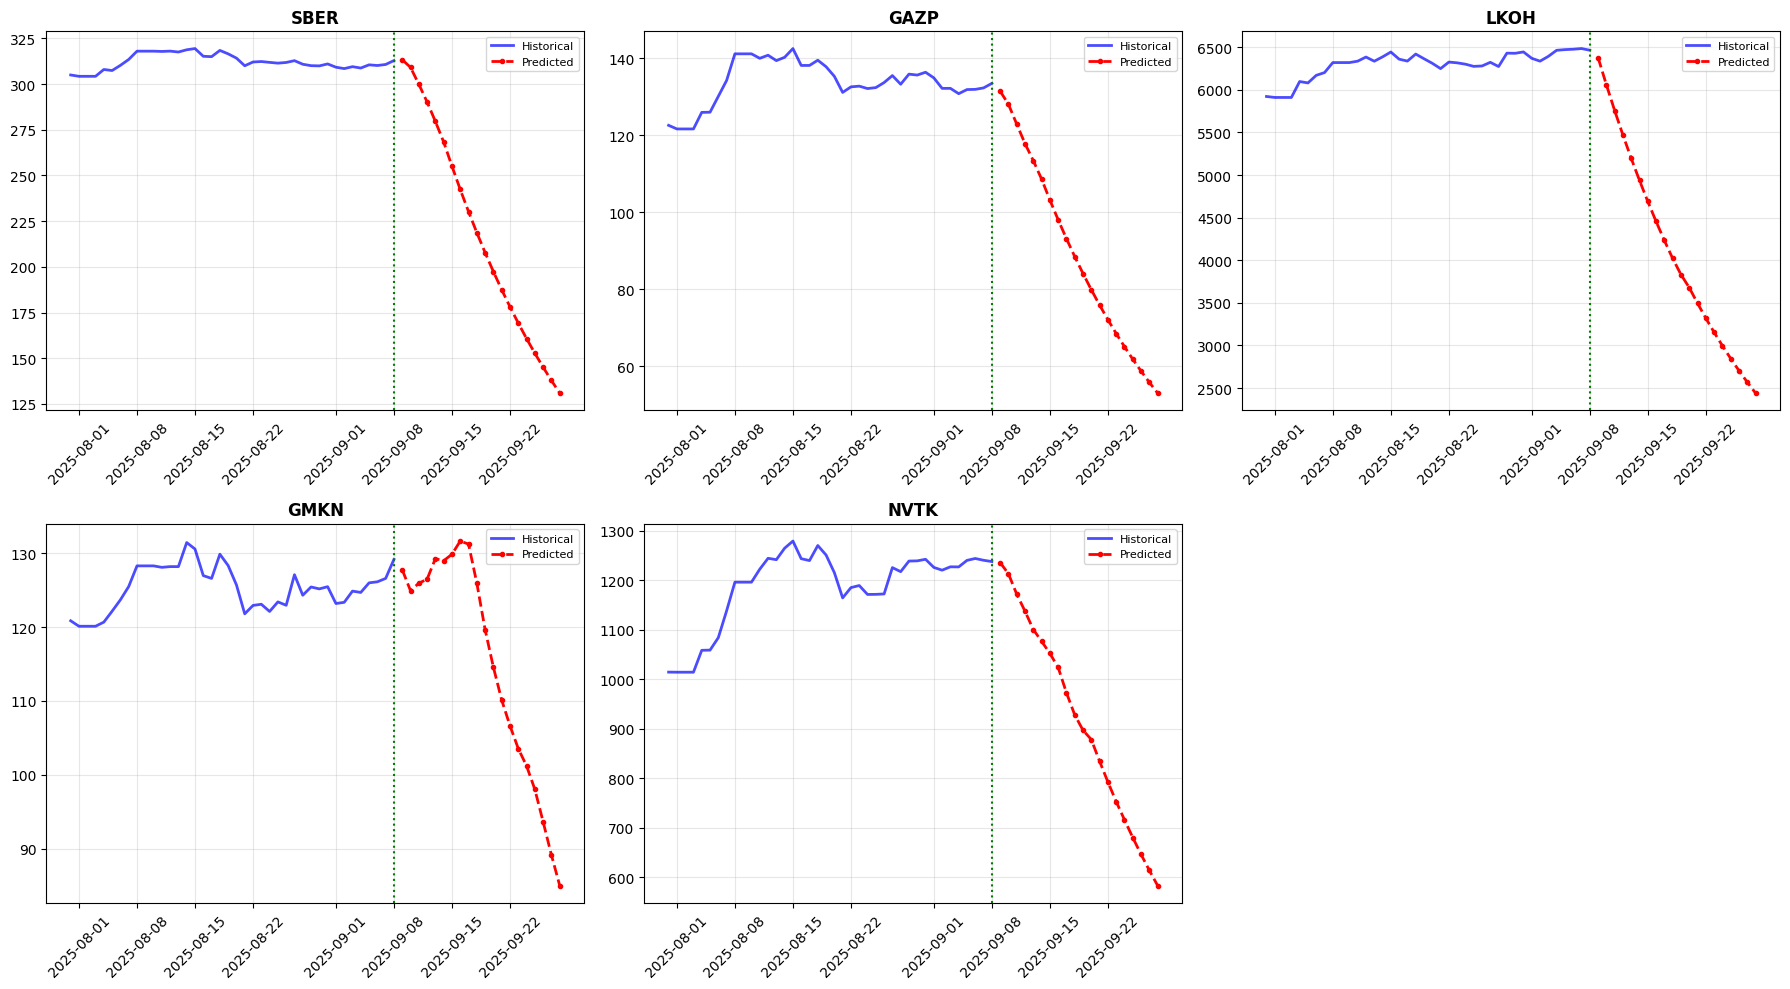

In [24]:


import matplotlib.pyplot as plt

print("\n📊 7. Визуализация предсказаний для топ-5 тикеров...\n")

top_tickers = ['SBER', 'GAZP', 'LKOH', 'GMKN', 'NVTK']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, ticker in enumerate(top_tickers):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    df_t = CANDLES[CANDLES['ticker'] == ticker].copy()
    llm_ticker = LLM_FEATURES_DF[LLM_FEATURES_DF['ticker'] == ticker].copy()
    
    if len(df_t) < INPUT_WINDOW:
        ax.set_title(f"{ticker} - Not enough data")
        continue

    try:
        forecast = generate_forecast(
            trained_model, df_t, llm_ticker, feature_scaler, TRAIN_CUTOFF
        )
        daily_r = forecast['R']
        pred_prices = [df_t['close'].iloc[-1]]
        for r in daily_r:
            pred_prices.append(pred_prices[-1] * (1 + r))
        pred_prices = np.array(pred_prices[1:])
    except Exception as e:
        ax.set_title(f"{ticker} - Prediction Error: {e}")
        continue

    df_plot = df_t.groupby("begin").agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum"
    }).reset_index()
    df_plot = df_plot.set_index("begin").asfreq("D").ffill()
    
    last_date = df_plot.index[-1]
    pred_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=PRED_HORIZON)
    
    ax.plot(df_plot.index[-40:], df_plot["close"][-40:], 
              label="Historical", linewidth=2, color='blue', alpha=0.7)
    ax.plot(pred_dates, pred_prices, 
              label="Predicted", linestyle="--", linewidth=2, marker='o', markersize=3, color='red')
    ax.axvline(x=last_date, color='green', linestyle=':', linewidth=1.5)
    ax.set_title(f"{ticker}", fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    # Поворот дат на оси X
    ax.tick_params(axis='x', rotation=45)

    
if len(axes) > len(top_tickers):
    for extra_ax in axes[len(top_tickers):]:
        extra_ax.axis('off')

plt.tight_layout()
plt.show()



In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.preprocessing import RobustScaler
import warnings
import os
import time
from tqdm import tqdm
import torch.nn.functional as F
import json
import re
import time
import json
from openai import (
    OpenAI, 
    APIStatusError, 
    APIConnectionError, 
    RateLimitError,
    AuthenticationError 
)
warnings.filterwarnings('ignore')

SEED = 42
CANDLES_PATH_1 = "/kaggle/input/finam-hackathon/candles.csv"
CANDLES_PATH_2 = "/kaggle/input/finam-hackathon/candles_2.csv"
NEWS_PATH_1 = "/kaggle/input/finam-hackathon/news.csv"
NEWS_PATH_2 = "/kaggle/input/finam-hackathon/news_2.csv"
TRAIN_CUTOFF = pd.Timestamp('2025-09-08')
INPUT_WINDOW = 60
PRED_HORIZON = 20
INPUT_DIM = 21
OPENROUTE_API_KEY = "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"

np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("\n 1. Загрузка и объединение данных...")
def load_and_merge_data():
    candles_1 = pd.read_csv(CANDLES_PATH_1)
    candles_2 = pd.read_csv(CANDLES_PATH_2)
    candles_df = pd.concat([candles_1, candles_2], ignore_index=True)
    news_1 = pd.read_csv(NEWS_PATH_1)
    news_2 = pd.read_csv(NEWS_PATH_2)
    news_df = pd.concat([news_1, news_2], ignore_index=True)
    if 'begin' in candles_df.columns:
        candles_df["begin"] = pd.to_datetime(candles_df["begin"])
        candles_df = candles_df.sort_values(['ticker', 'begin']).reset_index(drop=True)
    if 'publish_date' in news_df.columns:
        news_df["publish_date"] = pd.to_datetime(news_df["publish_date"])
    
    return candles_df, news_df
CANDLES, NEWS = load_and_merge_data()
TRAIN_TICKERS = CANDLES[CANDLES['begin'] <= TRAIN_CUTOFF]['ticker'].unique()
TICKER_KEYWORDS = {
    "GAZP": ["Газпром", "Gazprom", "ГАЗП", "Gazprom Neft", "Нефть", "Трамп", "Путин"],
    "SBER": ["Сбербанк", "Sberbank", "СБЕР", "Сбер", "Банк", "Ключевая ставка", "Трамп", "Путин"],
    "SBERP": ["Сбербанк-п", "Sberbank-p", "СБЕР-п", "Банк", "Ключевая ставка", "Трамп", "Путин"],
    "LKOH": ["Лукойл", "Lukoil", "ЛУКОЙЛ", "Трамп", "Путин"],
    "GMKN": ["Норникель", "Nornickel", "ГМК", "Трамп", "Путин"],
    "YNDX": ["Яндекс", "Yandex", "YNDX", "Трамп", "Путин"],
    "VTBR": ["ВТБ", "VTB", "ВТБ Банк", "Банк", "Ключевая ставка", "Трамп", "Путин"],
    "ROSN": ["Роснефть", "Rosneft", "РОСНЕФТЬ", "Трамп", "Путин"],
    "NVTK": ["НОВАТЭК", "Novatek", "Трамп", "Путин"],
    "SIBN": ["Газпром нефть", "Gazprom Neft", "ГАЗПРОМ НЕФТЬ", "Трамп", "Путин"],
    "PHOR": ["ФосАгро", "PhosAgro", "ФОСАГРО", "Трамп", "Путин"],
    "PLZL": ["Полюс Золото", "Polyus", "ПОЛЮС", "Трамп", "Путин"],
    "MTSS": ["МТС", "MTS", "МТС Банк", "Трамп", "Путин"],
    "MGNT": ["Магнит", "Magnit", "МАГНИТ", "Трамп", "Путин"],
    "CHMF": ["Северсталь", "Severstal", "СЕВЕРСТАЛЬ", "Трамп", "Путин"],
    "NLMK": ["НЛМК", "NLMK", "Новолипецкий металлургический комбинат", "Трамп", "Путин"],
    "ALRS": ["АЛРОСА", "Alrosa", "Трамп", "Путин"],
    "RUAL": ["РУСАЛ", "Rusal", "Трамп", "Путин"],
    "AFKS": ["АФК Система", "AFK Sistema", "СИСТЕМА", "Трамп", "Путин"],
    "MOEX": ["Московская биржа", "MOEX", "БИРЖА", "Трамп", "Путин"],
    "HYDR": ["РусГидро", "RusHydro", "РУСГИДРО", "Трамп", "Путин"],
    "IRAO": ["Интер РАО", "Inter RAO", "ИНТЕР РАО", "Трамп", "Путин"],
    "AFLT": ["Аэрофлот", "Aeroflot", "АЭРОФЛОТ", "Трамп", "Путин"],
    "SNGS": ["Сургутнефтегаз", "Surgutneftegas", "СНГ", "Трамп", "Путин"],
    "SNGSP": ["Сургутнефтегаз-п", "Surgutneftegas-p", "СНГ-п", "Трамп", "Путин"],
    "TATN": ["Татнефть", "Tatneft", "ТАТНЕФТЬ", "Трамп", "Путин"],
    "TATNP": ["Татнефть-п", "Tatneft-p", "ТАТНЕФТЬ-п", "Трамп", "Путин"],
    "VTBRP": ["ВТБ-п", "VTB-p", "ВТБ Банк-п", "Трамп", "Путин"],
    "MGNP": ["Магнит-п", "Magnit-p", "МАГНИТ-п", "Трамп", "Путин"],
    "TRNFP": ["Транснефть", "Transneft", "ТРАНСНЕФТЬ", "Трамп", "Путин"],
    "TRNF": ["Транснефть", "Transneft", "ТРАНСНЕФТЬ", "Трамп", "Путин"],
    "URKA": ["Уралкалий", "Uralkali", "УРАЛКАЛИЙ", "Трамп", "Путин"],
    "URKAP": ["Уралкалий-п", "Uralkali-p", "УРАЛКАЛИЙ-п", "Трамп", "Путин"],
    "BANE": ["Башнефть", "Bashneft", "Трамп", "Путин"],
    "FESH": ["ДВМП", "Дальневосточное морское пароходство", "FESCO", "Трамп", "Путин"],
    "UWGN": ["ОВК", "Объединенная вагонная компания", "ОВК", "Трамп", "Путин"],
    "T": ["Тинькофф Банк", "Tinkoff", "ТИНЬКОФФ", "Т-Банк", "Т", "Банк", "Ключевая ставка", "IT", "Трамп", "Путин"],
    "VKCO": ["VK Company", "VK", "ВКОНТАКТЕ", "IT", "Трамп", "Путин"],
    "PIKK": ["ПИК-специализированный застройщик", "PIK", "ПИК", "Трамп", "Путин"],
    "SMLT": ["Самолет", "Samolet", "САМОЛЕТ", "Трамп", "Путин"],
    "POSI": ["Positive Technologies", "ПОЗИТИВ", "Трамп", "Путин"],
    "FIVE": ["X5 Retail Group", "X5", "Х5", "Трамп", "Путин"],
    "SVCB": ["Совкомбанк", "Sovcombank", "СОВКОМБАНК", "Трамп", "Путин"],
    "SVCBP": ["Совкомбанк-п", "Sovcombank-p", "СОВКОМБАНК-п", "Трамп", "Путин"],
    "CIAN": ["ЦИАН", "CIAN Group", "ЦИАН ГРУПП", "Трамп", "Путин"],
    "HHRU": ["HeadHunter", "Хедхантер", "HH", "IT", "Трамп", "Путин"],
    "DELI": ["Делимобиль", "Delimobil", "ДЕЛИМОБИЛЬ", "Трамп", "Путин"],
    "DIAS": ["Диасофт", "Diasoft", "DIASOFT", "Трамп", "Путин"],
    "EVI": ["Европлан", "Europlan", "ЕВРОПЛАН", "Трамп", "Путин"],
    "MTBC": ["МТС Банк", "MTS Bank", "МТС-БАНК", "Трамп", "Путин"],
    "OZON": ["Озон", "Ozon Holdings", "OZON", "IT", "Трамп", "Путин"],
    "DATA": ["Аренадата", "Arenadata", "DATA", "Трамп", "Путин"],
    "SPBE": ["СПБ Биржа", "SPB Exchange", "СПБ", "Трамп", "Путин"],
    "CBOM": ["МКБ", "Moscow Credit Bank", "МОСКОВСКИЙ КРЕДИТНЫЙ БАНК", "Трамп", "Путин"],
    "PRMB": ["Промсвязьбанк", "PSB", "ПСБ", "Трамп", "Путин"],
    "ABIO": ["Астра", "ГК Астра", "Astra Group", "ASTRA", "Трамп", "Путин"],
    "SOFL": ["Софтлайн", "Softline", "СОФТЛАЙН", "Трамп", "Путин"],
    "DELPO": ["Депозитарный расписки", "Депозитарные расписки", "ГДР", "Трамп", "Путин"],
    "RASP": ["Распадская", "Raspadskaya", "РАСПАДСКАЯ", "Трамп", "Путин"],
    "POLY": ["Полиметалл", "Polymetal", "ПОЛИМЕТАЛЛ", "Трамп", "Путин"],
    "RUALP": ["РУСАЛ-п", "Rusal-p"],
    "MAGN": ["ММК", "MMK", "Магнитогорский металлургический комбинат", "Трамп", "Путин"],
    "MSNG": ["Мечел", "Mechel", "МЕЧЕЛ", "Трамп", "Путин"],
    "TRMK": ["ТМК", "Трубная металлургическая компания", "TMK", "Трамп", "Путин"],
    "KMAZ": ["КАМАЗ", "KAMAZ", "КАМАЗ", "Трамп", "Путин"],
    "VSMO": ["ВСМПО-Ависма", "VSMPO-AVISMA", "Трамп", "Путин"],
    "AKRN": ["Акрон", "Acron", "Трамп", "Путин"],
    "KZOS": ["Казаньоргсинтез", "Kazanorgsintez", "КОС", "Трамп", "Путин"],
    "GCHE": ["Группа Черкизово", "Cherkizovo Group", "ЧЕРКИЗОВО", "Трамп", "Путин"],
    "RZSP": ["Русагро", "Rusagro", "РУСАГРО", "Трамп", "Путин"],
    "RZSPP": ["Русагро-п", "Rusagro-p", "РУСАГРО-п", "Трамп", "Путин"],
    "OKEY": ["О'КЕЙ", "O'KEY", "ОКЕЙ", "Трамп", "Путин"],
    "APTK": ["Аптечная сеть 36,6", "APTEKA 36,6", "АПТЕКА", "Трамп", "Путин"],
    "DIXY": ["Дикси Групп", "DIXY Group", "ДИКСИ", "Трамп", "Путин"],
    "ABRD": ["Абрау-Дюрсо", "Abrau-Durso", "АБРАУ", "Трамп", "Путин"],
    "MRKC": ["Россети Центр", "MRSK Center", "МРСК ЦЕНТРА", "Трамп", "Путин"],
    "MRKU": ["Россети Урал", "MRSK Urala", "МРСК УРАЛА", "Трамп", "Путин"],
    "MRKP": ["Россети Центр и Приволжье", "MRSK Center & Privolzhye", "МРСК ЦИП", "Трамп", "Путин"],
    "MRKV": ["Россети Волга", "MRSK Volga", "МРСК ВОЛГА", "Трамп", "Путин"],
    "MSRS": ["Россети Московский регион", "МОЭСК", "MSRS", "Трамп", "Путин"],
    "MRKK": ["Россети Северный Кавказ", "MRK-SK", "РОССЕТИ СК", "Трамп", "Путин"],
    "MRKY": ["Россети Юг", "MRK-Yug", "РОССЕТИ ЮГ", "Трамп", "Путин"],
    "MRKZ": ["Россети Северо-Запад", "MRSK SZ", "МРСК СЗ", "Трамп", "Путин"],
    "FEES": ["ФСК ЕЭС", "FSK EES", "ФСК", "Трамп", "Путин"],
    "OGKB": ["ОГК-2", "OGK-2", "Трамп", "Путин"],
    "TGKA": ["ТГК-1", "TGK-1", "Трамп", "Путин"],
    "TGLD": ["ТГК-1", "ТГК-1", "TGC-1", "Трамп", "Путин"],
    "TGKB": ["ТГК-2", "TGK-2", "Трамп", "Путин"],
    "TGKN": ["ТГК-14", "TGK-14", "Трамп", "Путин"],
    "BELU": ["Белуга Групп", "BELUGA Group", "БЕЛУГА", "Трамп", "Путин"],
    "ETLN": ["Эталон", "Etalon Group", "ЭТАЛОН", "Трамп", "Путин"],
    "SGZH": ["Сегежа Групп", "Segezha Group", "СЕГЕЖА", "Трамп", "Путин"],
    "LSRG": ["ЛСР", "LSR Group", "Группа ЛСР", "Трамп", "Путин"],
    "GEMC": ["Мать и дитя", "MD Medical Group", "МАТЬ И ДИТЯ", "Трамп", "Путин"],
    "AQUA": ["Аквакультура", "РусАквакультура", "AQUA", "Трамп", "Путин"],
    "RTKM": ["Ростелеком", "Rostelecom", "РОСТЕЛЕКОМ", "Трамп", "Путин"],
    "RTKMP": ["Ростелеком-п", "Rostelecom pref", "РОСТЕЛЕКОМ-п", "Трамп", "Путин"],
    "RENI": ["Ренессанс Страхование", "РЕНЕССАНС СТРАХОВАНИЕ", "Трамп", "Путин"],
    "ZAYM": ["Займер", "Zaymer", "ЗАЙМЕР", "Трамп", "Путин"],
    "ZAYMP": ["Займер-п", "Zaymer-p", "ЗАЙМЕР-п", "Трамп", "Путин"],
    "PHST": ["Фармсинтез", "Pharmasynthez", "ФАРМСИНТЕЗ", "Трамп", "Путин"],
    "RSG": ["РусГидро", "RusHydro", "РУСГИДРО", "Трамп", "Путин"],
    "LSNGP": ["Ленэнерго-п", "Lenenergo-p", "ЛЕНЭНЭРГО-п", "Трамп", "Путин"],
    "GAZT": ["ГАЗ-Тек", "GAZ-Tek", "ГАЗТЕК", "Трамп", "Путин"],
    "IRKT": ["Иркут", "Irkut", "Трамп", "Путин"],
    "UNAC": ["ОАК", "Объединённая авиастроительная корпорация", "Трамп", "Путин"],
    "NKNC": ["Нижнекамскнефтехим", "Nizhnekamskneftekhim", "Трамп", "Путин"],
    "CHKZ": ["Челябинский кузнечно-прессовый завод", "ЧКПЗ", "Трамп", "Путин"],
    "CHMK": ["Челябинский металлургический комбинат", "ЧМК", "Трамп", "Путин"],
    "ALNU": ["Алмазная промышленность", "ALNU", "Трамп", "Путин"],
    "OKB": ["ОК 'Русь'", "OK", "OKB", "Трамп", "Путин"],
    "ISKJ": ["ГК Самолет", "Samolet Group", "САМОЛЕТ-ИСК", "Трамп", "Путин"],
    "AKB": ["АК БАРС", "Ak Bars Bank", "АКБАРС", "Трамп", "Путин"]
}
def call_llm_for_features(news_text: str, ticker: str, api_key: str) -> tuple[int, int]:
    client = OpenAI(
        api_key=api_key,
        base_url="https://openrouter.ai/api/v1"
    )
    system_prompt = (
        "You are an expert financial analyst. Analyze the following news article for "
        f"stock ticker {ticker}. Output the result strictly in JSON format: "
        '{"sentiment": N, "impact": M}, where N is the sentiment (integer from -3 to 3, '
        'and M is the market impact (integer from 0 to 5). '
        "Do not include any other text or explanation."
    )
    
    max_retries = 3
    for attempt in range(max_retries):
        try:
            # print("\n" + "="*50)
            # print(f"[{ticker}]  Подготовка запроса к LLM:")
            # print(news_text[:500] + ("..." if len(news_text) > 500 else ""))
            # print("="*50)
            
            completion = client.chat.completions.create(
                extra_headers={"OpenRouter-App-Title": "Financial Feature Extractor"},
                model="openai/gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": news_text}
                ],
                response_format={"type": "json_object"},
                temperature=0.0
            )

            response_text = completion.choices[0].message.content
            data = json.loads(response_text)

            # print(f"[{ticker}]  Ответ LLM:")
            # print(json.dumps(data, indent=2, ensure_ascii=False))
            return data.get("sentiment", 0), data.get("impact", 0)

        except (APIStatusError, APIConnectionError, RateLimitError, json.JSONDecodeError) as e:
            print(f"[{ticker}]  Ошибка при вызове API: {type(e).__name__} - {e}")
            if attempt < max_retries - 1:
                print(f"[{ticker}] Повторная попытка ({attempt+2}/{max_retries})...")
                time.sleep(2 ** attempt)
                continue
            return 0, 0
        except Exception as e:
            print(f"[{ticker}]  Неожиданная ошибка: {type(e).__name__} - {e}")
            return 0, 0
    return 0, 0

class NewsFeatureExtractor:
    def __init__(self, news_df, candles_df, ticker_keywords, train_cutoff, api_key, max_api_calls=5000):
        self.news_df = news_df
        self.candles_df = candles_df
        self.ticker_keywords = ticker_keywords
        self.train_cutoff = train_cutoff
        self.api_key = api_key
        self.max_api_calls = max_api_calls
        self.llm_results = {}
        self.api_calls = 0
        self.log_records = []

    def extract_features(self, train_tickers):
        print(f" Запуск анализа новостей для тикеров из TRAIN...")
    
        for ticker, keywords in self.ticker_keywords.items():
            if ticker not in train_tickers:
                continue
    
            if self.api_calls >= self.max_api_calls:
                print(" Достигнут лимит API вызовов")
                break
    
            keyword_pattern = '|'.join([re.escape(k) for k in keywords])
            news_filtered = self.news_df[
                self.news_df['title'].str.contains(keyword_pattern, case=False, na=False)
            ].copy()
    
            if news_filtered.empty:
                continue
    
            news_filtered.sort_values('publish_date', inplace=True, ascending=False)
            recent_news = news_filtered.head(30)
    
            results = []
            for _, row in recent_news.iterrows():
                if self.api_calls >= self.max_api_calls:
                    break
    
                news_text = f"Title: {row['title']}\nPublication: {row['publication']}"
                response = call_llm_for_features(news_text, ticker, self.api_key)
                self.api_calls += 1
    
                self.log_records.append({
                    'ticker': ticker,
                    'date': row['publish_date'],
                    'title': row['title'],
                    'publication': row['publication'],
                    'llm_response': response
                })
    
                if response:
                    results.append(response)
    
            if results:
                self.llm_results[ticker] = results
    
        if self.log_records:
            import pandas as pd
            pd.DataFrame(self.log_records).to_csv('llm_news_logs.csv', index=False, encoding='utf-8-sig')
            print(f" LLM анализ новостей сохранён ({len(self.log_records)} записей)")
    
        return self.llm_results




class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.layers = nn.ModuleList()
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            conv = nn.Conv1d(
                in_channels, out_channels, kernel_size,
                padding=(dilation_size * (kernel_size - 1)) // 2, 
                dilation=dilation_size
            )
            self.layers.append(nn.Sequential(
                conv,
                nn.BatchNorm1d(out_channels),
                nn.ReLU(),
                nn.Dropout(dropout)
            ))
        
        self.output_channels = num_channels[-1]
    
    def forward(self, x):
        x = x.transpose(1, 2)
        for layer in self.layers:
            x = layer(x)
        return x.transpose(1, 2) 

class ImprovedForecastModel(nn.Module):
    def __init__(self, input_dim=23, hidden_dim=128, num_layers=4, 
                 num_heads=8, dropout=0.2, pred_horizon=20):
        super().__init__()
        
        self.pred_horizon = pred_horizon
        self.hidden_dim = hidden_dim
        
        self.feature_proj = nn.Linear(input_dim, hidden_dim)
        self.pos_encoder = PositionalEncoding(hidden_dim)
        self.tcn = TemporalConvNet(
            hidden_dim, 
            [hidden_dim, hidden_dim, hidden_dim],
            kernel_size=7,
            dropout=dropout
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation=F.gelu,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        self.final_repr_proj = nn.Linear(3 * hidden_dim, hidden_dim)
        
        self.return_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim // 2, 1)
            ) for _ in range(pred_horizon)
        ])
        
        self.prob_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim // 2, 1),
                nn.Sigmoid()
            ) for _ in range(pred_horizon)
        ])
        
        self.global_return_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, pred_horizon)
        )
    
    def forward(self, x):
        x = self.feature_proj(x)
        x = self.pos_encoder(x)
        
        tcn_out = self.tcn(x)
        trans_out = self.transformer(x)
        combined = tcn_out + trans_out + x
        attn_output, _ = self.attention(combined, combined, combined)
        last_state = attn_output[:, -1, :]
        avg_state = attn_output.mean(dim=1)
        max_state = attn_output.max(dim=1)[0]
        pooled = torch.cat([last_state, avg_state, max_state], dim=-1)
        final_repr = self.final_repr_proj(pooled)
        
        daily_returns = []
        daily_probs = []
        
        for i in range(self.pred_horizon):
            daily_returns.append(self.return_heads[i](final_repr))
            daily_probs.append(self.prob_heads[i](final_repr))
        
        daily_returns = torch.cat(daily_returns, dim=1)
        daily_probs = torch.cat(daily_probs, dim=1)
        global_returns = self.global_return_head(final_repr)
        final_returns = 0.7 * daily_returns + 0.3 * global_returns
        
        return final_returns, daily_probs
class ImprovedTimeSeriesDataset(Dataset):
    def __init__(self, df, llm_features_df, seq_len=60, pred_horizon=20,
                 feature_scaler=None, is_train=True, llm_weight=0.3):
        
        self.seq_len = seq_len
        self.pred_horizon = pred_horizon
        self.is_train = is_train
        self.llm_weight = llm_weight

        df_agg = df.groupby("begin").agg({
            "open": "first",
            "high": "max",
            "low": "min",
            "close": "last",
            "volume": "sum"
        }).reset_index()
        df_agg = df_agg.set_index("begin").asfreq("D").ffill().reset_index()

        llm_features_df_shifted = llm_features_df.copy()
        llm_features_df_shifted['begin'] = llm_features_df_shifted['begin'] + pd.Timedelta(days=1)

        llm_features_df_shifted = llm_features_df_shifted.drop_duplicates(subset=['ticker', 'begin'])
        df_agg = pd.merge(df_agg, llm_features_df_shifted.drop(columns='ticker', errors='ignore'), 
                          on='begin', how='left')

        llm_cols = [col for col in llm_features_df_shifted.columns if col not in ['ticker', 'begin']]
        for col in llm_cols:
            df_agg[col] = df_agg[col].fillna(0.0)

        self.features = self._create_features(df_agg, llm_cols)
        if is_train:
            self.targets = self._create_targets(df_agg)
        else:
            self.targets = None
        
        self.close_prices = df_agg['close'].values

        if feature_scaler is None:
            self.feature_scaler = RobustScaler()
            if self.features.size > 0:
                self.features = self.feature_scaler.fit_transform(self.features)
        else:
            self.feature_scaler = feature_scaler
            if self.features.size > 0:
                self.features = self.feature_scaler.transform(self.features)
        
        self.valid_indices = self._get_valid_indices()

    def _create_features(self, df, llm_cols):
        features = []
        cols = ['open', 'high', 'low', 'close', 'volume']

        features.append(np.log(df['open']).values)
        features.append(np.log(df['high']).values)
        features.append(np.log(df['low']).values)
        features.append(np.log(df['close']).values)
        features.append(np.log(df['volume'] + 1).values)

        log_returns = np.log(df['close'] / df['close'].shift(1)).fillna(0)
        features.append(log_returns.values)
        features.append(log_returns.rolling(20).std().fillna(0).values)

        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        features.append(rsi.fillna(50).values / 100.0)

        ma5 = df['close'].rolling(5).mean()
        ma20 = df['close'].rolling(20).mean()
        features.append((ma5 / ma20 - 1).fillna(0).values)

        features.append((df['volume'] / df['volume'].shift(1) - 1).fillna(0).values)
        features.append(((df['high'] - df['low']) / df['close']).values)

        ema12 = df['close'].ewm(span=12, adjust=False).mean()
        ema26 = df['close'].ewm(span=26, adjust=False).mean()
        macd = ema12 - ema26
        features.append((macd / df['close']).fillna(0).values * 10)

        high_low = df['high'] - df['low']
        high_prevclose = np.abs(df['high'] - df['close'].shift(1))
        low_prevclose = np.abs(df['low'] - df['close'].shift(1))
        tr = pd.DataFrame({'hl': high_low, 'hpc': high_prevclose, 'lpc': low_prevclose}).max(axis=1)
        atr = tr.rolling(14).mean()
        features.append((atr / df['close']).fillna(0).values * 10)

        momentum = df['close'].diff(10) / df['close'].shift(10)
        features.append(momentum.fillna(0).values)

        features.append(df['close'].rolling(30).std().fillna(0).values / df['close'].mean())

        vol_ma10 = df['volume'].rolling(10).mean()
        features.append((df['volume'] / vol_ma10 - 1).fillna(0).values)

        high_10 = df['high'].rolling(10).max()
        low_10 = df['low'].rolling(10).min()
        features.append(((df['close'] - low_10) / (high_10 - low_10 + 1e-8)).fillna(0.5).values)

        typical_price = (df['high'] + df['low'] + df['close']) / 3
        features.append((typical_price / typical_price.shift(1) - 1).fillna(0).values)

        ma50 = df['close'].rolling(50).mean()
        features.append((df['close'] / ma50 - 1).fillna(0).values)

        for col in llm_cols:
            features.append(df[col].values * self.llm_weight)

        current_dim = len(features)
        if current_dim < INPUT_DIM:
            for _ in range(INPUT_DIM - current_dim):
                features.append(np.zeros(len(df)))

        features = features[:INPUT_DIM]

        return np.column_stack(features)

    
    def _create_targets(self, df):
        returns = []
        directions = []
        
        for h in range(1, self.pred_horizon + 1):
            if len(df['close']) <= h:
                ret = np.full(len(df), np.nan)
            else:
                ret = (df['close'].shift(-h) / df['close'] - 1).values
            
            returns.append(ret)
            directions.append((ret > 0).astype(float))
        
        return {
            'returns': np.column_stack(returns),
            'directions': np.column_stack(directions)
        }
    
    def _get_valid_indices(self):
        valid = []

        if self.features.size == 0:
            return []
            
        end_idx = len(self.features) - self.pred_horizon if self.is_train else len(self.features)
        
        for i in range(self.seq_len, end_idx):
            if not np.isnan(self.features[i-self.seq_len:i]).any():
                if self.is_train and self.targets:
                    if not np.isnan(self.targets['returns'][i]).any():
                        valid.append(i)
                else:
                    valid.append(i)
        return valid
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        i = self.valid_indices[idx]
        X = torch.FloatTensor(self.features[i-self.seq_len:i])
        
        if self.is_train and self.targets:
            y_returns = torch.FloatTensor(self.targets['returns'][i])
            y_directions = torch.FloatTensor(self.targets['directions'][i])
            return X, y_returns, y_directions
        else:
            return X, torch.zeros(self.pred_horizon), torch.zeros(self.pred_horizon)


class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.3, gamma=0.2):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.mse = nn.MSELoss()
        self.bce = nn.BCELoss()
    
    def forward(self, pred_returns, pred_probs, true_returns, true_directions):
        loss_mse = self.mse(pred_returns, true_returns)
        loss_bce = self.bce(pred_probs, true_directions)

        pred_directions = (pred_returns > 0).float()
        loss_dir = 1.0 - (pred_directions == true_directions).float().mean()
        
        return self.alpha * loss_mse + self.beta * loss_bce + self.gamma * loss_dir

def train_model(model, train_loader, val_loader, epochs=15, lr=1e-4, patience=5):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    criterion = CombinedLoss()
    mse_criterion = nn.MSELoss()
    bce_criterion = nn.BCELoss()
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_batches = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Train)")
        for X, y_returns, y_directions in pbar:
            X = X.to(device)
            y_returns = y_returns.to(device)
            y_directions = y_directions.to(device)
            
            optimizer.zero_grad()
            pred_returns, pred_probs = model(X)
            loss = criterion(pred_returns, pred_probs, y_returns, y_directions)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
            
        avg_train_loss = train_loss / train_batches

        model.eval()
        val_loss = 0.0
        val_mse_sum = 0.0
        val_bce_sum = 0.0
        val_dir_acc_sum = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for X, y_returns, y_directions in val_loader:
                X = X.to(device)
                y_returns = y_returns.to(device)
                y_directions = y_directions.to(device)
                
                pred_returns, pred_probs = model(X)

                loss = criterion(pred_returns, pred_probs, y_returns, y_directions)
                val_loss += loss.item()

                val_mse_sum += mse_criterion(pred_returns, y_returns).item()
                val_bce_sum += bce_criterion(pred_probs, y_directions).item()
                pred_directions = (pred_returns > 0).float()
                val_dir_acc_sum += (pred_directions == y_directions).float().mean().item()

                val_batches += 1
        
        avg_val_loss = val_loss / val_batches
        avg_val_mse = val_mse_sum / val_batches
        avg_val_bce = val_bce_sum / val_batches
        avg_val_acc = val_dir_acc_sum / val_batches
        
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val MSE: {avg_val_mse:.5f} | Val BCE: {avg_val_bce:.4f} | Val Acc: {avg_val_acc:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    if os.path.exists('best_model.pt'):
        model.load_state_dict(torch.load('best_model.pt'))
    return model

extractor = NewsFeatureExtractor(
    NEWS, CANDLES, TICKER_KEYWORDS,
    TRAIN_CUTOFF, OPENROUTE_API_KEY
)
LLM_FEATURES = extractor.extract_features(train_tickers=TRAIN_TICKERS)

llm_rows = []
for ticker, results_list in LLM_FEATURES.items():
    for i, (sentiment, impact) in enumerate(results_list):
        date = extractor.log_records[i]['date'] if i < len(extractor.log_records) else None
        llm_rows.append({
            'ticker': ticker,
            'begin': date,
            'sentiment': sentiment,
            'impact': impact
        })

LLM_FEATURES_DF = pd.DataFrame(llm_rows)
LLM_FEATURES_DF['begin'] = pd.to_datetime(LLM_FEATURES_DF['begin'])

ticker_data = {}
for ticker in TRAIN_TICKERS:
    df_ticker = CANDLES[CANDLES['ticker'] == ticker].copy()
    llm_ticker = LLM_FEATURES_DF[LLM_FEATURES_DF['ticker'] == ticker].copy()
    
    df_train = df_ticker[df_ticker['begin'] <= TRAIN_CUTOFF].copy()
    val_start = TRAIN_CUTOFF - pd.Timedelta(days=INPUT_WINDOW)
    df_val = df_ticker[df_ticker['begin'] >= val_start].copy()
    
    ticker_data[ticker] = {
        'train': df_train,
        'val': df_val,
        'llm': llm_ticker
    }

val_window = 200

train_datasets = []
val_datasets = []
feature_scaler = None

for i, ticker in enumerate(TRAIN_TICKERS):
    data = ticker_data[ticker]
    
    if len(data['train']) < INPUT_WINDOW + PRED_HORIZON:
        continue

    df_train = data['train'].iloc[:-val_window] 
    train_ds = ImprovedTimeSeriesDataset(
        df_train,
        data['llm'],
        seq_len=INPUT_WINDOW,
        pred_horizon=PRED_HORIZON,
        is_train=True
    )
    if i == 0:
        feature_scaler = train_ds.feature_scaler
    if len(train_ds) > 0:
        train_datasets.append(train_ds)

    df_val = data['train'].iloc[-val_window:] 
    val_ds = ImprovedTimeSeriesDataset(
        df_val,
        data['llm'],
        seq_len=INPUT_WINDOW,
        pred_horizon=PRED_HORIZON,
        feature_scaler=feature_scaler,
        is_train=True
    )
    if len(val_ds) > 0:
        val_datasets.append(val_ds)

train_dataset = ConcatDataset(train_datasets)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

val_dataset = ConcatDataset(val_datasets) if val_datasets else None
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False) if val_dataset else None

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset) if val_dataset else 0}")


print("\n Обучение модели")

model = ImprovedForecastModel(
    input_dim=INPUT_DIM,
    pred_horizon=PRED_HORIZON
).to(device)

print(f"Model on: {device}")

trained_model = train_model(
    model,
    train_loader,
    val_loader,
    epochs=10,
    lr=5e-4,
    patience=5
)


print("\n Генерация прогнозов")

def generate_forecast(model, df_ticker, llm_ticker, feature_scaler, date_t, clip_pct=0.05, smooth_window=3):
    """
    Генерирует прогноз на следующие PRED_HORIZON дней, используя последние INPUT_WINDOW дней.
    Применяется скользящее среднее сглаживание и ограничение экстремумов.
    """
    model.eval()

    df_cut = df_ticker[df_ticker['begin'] <= date_t].copy()
    if len(df_cut) < INPUT_WINDOW:
        return {'R': np.zeros(PRED_HORIZON), 'P': np.zeros(PRED_HORIZON), 'prices': np.zeros(PRED_HORIZON)}

    ds = ImprovedTimeSeriesDataset(
        df_cut,
        llm_ticker,
        seq_len=INPUT_WINDOW,
        pred_horizon=PRED_HORIZON,
        feature_scaler=feature_scaler,
        is_train=False
    )
    
    if len(ds) == 0:
        return {'R': np.zeros(PRED_HORIZON), 'P': np.zeros(PRED_HORIZON), 'prices': np.zeros(PRED_HORIZON)}

    X, _, _ = ds[-1]
    X = X.unsqueeze(0).to(device)
    
    with torch.no_grad():
        pred_log_returns, pred_probs = model(X)
    
    pred_log_returns = pred_log_returns.cpu().numpy().flatten()

    if smooth_window > 1:
        pred_log_returns = pd.Series(pred_log_returns).rolling(window=smooth_window, min_periods=1, center=True).mean().values

    pred_log_returns = np.clip(pred_log_returns, -clip_pct, clip_pct)

    last_price = df_cut['close'].iloc[-1]
    pred_prices = last_price * np.exp(np.cumsum(pred_log_returns))
    
    return {
        'R': pred_log_returns,
        'P': pred_probs.cpu().numpy().flatten(),
        'prices': pred_prices
    }

all_train_tickers = TRAIN_TICKERS  
submission_rows = []

for ticker in tqdm(all_train_tickers, desc="Generating forecasts"):
    df_ticker = CANDLES[CANDLES['ticker'] == ticker].copy()
    llm_ticker = LLM_FEATURES_DF[LLM_FEATURES_DF['ticker'] == ticker].copy()

    df_cut = df_ticker[df_ticker['begin'] <= TRAIN_CUTOFF].copy()
    
    if len(df_cut) < INPUT_WINDOW:
        R = np.zeros(PRED_HORIZON)
    else:
        forecast = generate_forecast(
            trained_model,
            df_cut,
            llm_ticker,
            feature_scaler,
            TRAIN_CUTOFF
        )
        daily_log_r = forecast['R']
        R = np.exp(np.cumsum(daily_log_r)) - 1
    
    submission_rows.append([ticker] + R.tolist())

columns = ['ticker'] + [f'p{i+1}' for i in range(PRED_HORIZON)]
submission_df = pd.DataFrame(submission_rows, columns=columns).set_index('ticker')

print(f"\n Прогнозы готовы для {len(submission_df)} тикеров")
print(submission_df.head())

submission_df.to_csv('forecast_results.csv', index=True)
print(f" Сохранено в: forecast_results.csv")



 1. Загрузка и объединение данных...
 Запуск анализа новостей для тикеров из TRAIN...
 LLM анализ новостей сохранён (570 записей)
Train samples: 30851
Val samples: 2359

 Обучение модели
Model on: cuda


Epoch 1/10 (Train): 100%|██████████| 483/483 [01:53<00:00,  4.27it/s, Loss=0.3356]


Epoch 1 | Train Loss: 0.2964 | Val Loss: 1.7287 | Val MSE: 0.50350 | Val BCE: 4.6053 | Val Acc: 0.5234


Epoch 2/10 (Train):  84%|████████▍ | 406/483 [01:35<00:18,  4.23it/s, Loss=0.3145]


KeyboardInterrupt: 

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.preprocessing import RobustScaler
import warnings
import os
import time
from tqdm import tqdm
import torch.nn.functional as F
import json
import re
import time
import json
from openai import (
    OpenAI, 
    APIStatusError, 
    APIConnectionError, 
    RateLimitError,
    AuthenticationError 
)
warnings.filterwarnings('ignore')

SEED = 42
CANDLES_PATH_1 = "/kaggle/input/finam-hackathon/candles.csv"
CANDLES_PATH_2 = "/kaggle/input/finam-hackathon/candles_2.csv"
NEWS_PATH_1 = "/kaggle/input/finam-hackathon/news.csv"
NEWS_PATH_2 = "/kaggle/input/finam-hackathon/news_2.csv"
TRAIN_CUTOFF = pd.Timestamp('2025-09-08')
INPUT_WINDOW = 60
PRED_HORIZON = 20
INPUT_DIM = 21
OPENROUTE_API_KEY = "key"

np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("\n 1. Загрузка и объединение данных...")
def load_and_merge_data():
    candles_1 = pd.read_csv(CANDLES_PATH_1)
    candles_2 = pd.read_csv(CANDLES_PATH_2)
    candles_df = pd.concat([candles_1, candles_2], ignore_index=True)
    news_1 = pd.read_csv(NEWS_PATH_1)
    news_2 = pd.read_csv(NEWS_PATH_2)
    news_df = pd.concat([news_1, news_2], ignore_index=True)
    if 'begin' in candles_df.columns:
        candles_df["begin"] = pd.to_datetime(candles_df["begin"])
        candles_df = candles_df.sort_values(['ticker', 'begin']).reset_index(drop=True)
    if 'publish_date' in news_df.columns:
        news_df["publish_date"] = pd.to_datetime(news_df["publish_date"])
    
    return candles_df, news_df
CANDLES, NEWS = load_and_merge_data()
TRAIN_TICKERS = CANDLES[CANDLES['begin'] <= TRAIN_CUTOFF]['ticker'].unique()
TICKER_KEYWORDS = {
    "GAZP": ["Газпром", "Gazprom", "ГАЗП", "Gazprom Neft", "Нефть", "Трамп", "Путин"],
    "SBER": ["Сбербанк", "Sberbank", "СБЕР", "Сбер", "Банк", "Ключевая ставка", "Трамп", "Путин"],
    "SBERP": ["Сбербанк-п", "Sberbank-p", "СБЕР-п", "Банк", "Ключевая ставка", "Трамп", "Путин"],
    "LKOH": ["Лукойл", "Lukoil", "ЛУКОЙЛ", "Трамп", "Путин"],
    "GMKN": ["Норникель", "Nornickel", "ГМК", "Трамп", "Путин"],
    "YNDX": ["Яндекс", "Yandex", "YNDX", "Трамп", "Путин"],
    "VTBR": ["ВТБ", "VTB", "ВТБ Банк", "Банк", "Ключевая ставка", "Трамп", "Путин"],
    "ROSN": ["Роснефть", "Rosneft", "РОСНЕФТЬ", "Трамп", "Путин"],
    "NVTK": ["НОВАТЭК", "Novatek", "Трамп", "Путин"],
    "SIBN": ["Газпром нефть", "Gazprom Neft", "ГАЗПРОМ НЕФТЬ", "Трамп", "Путин"],
    "PHOR": ["ФосАгро", "PhosAgro", "ФОСАГРО", "Трамп", "Путин"],
    "PLZL": ["Полюс Золото", "Polyus", "ПОЛЮС", "Трамп", "Путин"],
    "MTSS": ["МТС", "MTS", "МТС Банк", "Трамп", "Путин"],
    "MGNT": ["Магнит", "Magnit", "МАГНИТ", "Трамп", "Путин"],
    "CHMF": ["Северсталь", "Severstal", "СЕВЕРСТАЛЬ", "Трамп", "Путин"],
    "NLMK": ["НЛМК", "NLMK", "Новолипецкий металлургический комбинат", "Трамп", "Путин"],
    "ALRS": ["АЛРОСА", "Alrosa", "Трамп", "Путин"],
    "RUAL": ["РУСАЛ", "Rusal", "Трамп", "Путин"],
    "AFKS": ["АФК Система", "AFK Sistema", "СИСТЕМА", "Трамп", "Путин"],
    "MOEX": ["Московская биржа", "MOEX", "БИРЖА", "Трамп", "Путин"],
    "HYDR": ["РусГидро", "RusHydro", "РУСГИДРО", "Трамп", "Путин"],
    "IRAO": ["Интер РАО", "Inter RAO", "ИНТЕР РАО", "Трамп", "Путин"],
    "AFLT": ["Аэрофлот", "Aeroflot", "АЭРОФЛОТ", "Трамп", "Путин"],
    "SNGS": ["Сургутнефтегаз", "Surgutneftegas", "СНГ", "Трамп", "Путин"],
    "SNGSP": ["Сургутнефтегаз-п", "Surgutneftegas-p", "СНГ-п", "Трамп", "Путин"],
    "TATN": ["Татнефть", "Tatneft", "ТАТНЕФТЬ", "Трамп", "Путин"],
    "TATNP": ["Татнефть-п", "Tatneft-p", "ТАТНЕФТЬ-п", "Трамп", "Путин"],
    "VTBRP": ["ВТБ-п", "VTB-p", "ВТБ Банк-п", "Трамп", "Путин"],
    "MGNP": ["Магнит-п", "Magnit-p", "МАГНИТ-п", "Трамп", "Путин"],
    "TRNFP": ["Транснефть", "Transneft", "ТРАНСНЕФТЬ", "Трамп", "Путин"],
    "TRNF": ["Транснефть", "Transneft", "ТРАНСНЕФТЬ", "Трамп", "Путин"],
    "URKA": ["Уралкалий", "Uralkali", "УРАЛКАЛИЙ", "Трамп", "Путин"],
    "URKAP": ["Уралкалий-п", "Uralkali-p", "УРАЛКАЛИЙ-п", "Трамп", "Путин"],
    "BANE": ["Башнефть", "Bashneft", "Трамп", "Путин"],
    "FESH": ["ДВМП", "Дальневосточное морское пароходство", "FESCO", "Трамп", "Путин"],
    "UWGN": ["ОВК", "Объединенная вагонная компания", "ОВК", "Трамп", "Путин"],
    "T": ["Тинькофф Банк", "Tinkoff", "ТИНЬКОФФ", "Т-Банк", "Т", "Банк", "Ключевая ставка", "IT", "Трамп", "Путин"],
    "VKCO": ["VK Company", "VK", "ВКОНТАКТЕ", "IT", "Трамп", "Путин"],
    "PIKK": ["ПИК-специализированный застройщик", "PIK", "ПИК", "Трамп", "Путин"],
    "SMLT": ["Самолет", "Samolet", "САМОЛЕТ", "Трамп", "Путин"],
    "POSI": ["Positive Technologies", "ПОЗИТИВ", "Трамп", "Путин"],
    "FIVE": ["X5 Retail Group", "X5", "Х5", "Трамп", "Путин"],
    "SVCB": ["Совкомбанк", "Sovcombank", "СОВКОМБАНК", "Трамп", "Путин"],
    "SVCBP": ["Совкомбанк-п", "Sovcombank-p", "СОВКОМБАНК-п", "Трамп", "Путин"],
    "CIAN": ["ЦИАН", "CIAN Group", "ЦИАН ГРУПП", "Трамп", "Путин"],
    "HHRU": ["HeadHunter", "Хедхантер", "HH", "IT", "Трамп", "Путин"],
    "DELI": ["Делимобиль", "Delimobil", "ДЕЛИМОБИЛЬ", "Трамп", "Путин"],
    "DIAS": ["Диасофт", "Diasoft", "DIASOFT", "Трамп", "Путин"],
    "EVI": ["Европлан", "Europlan", "ЕВРОПЛАН", "Трамп", "Путин"],
    "MTBC": ["МТС Банк", "MTS Bank", "МТС-БАНК", "Трамп", "Путин"],
    "OZON": ["Озон", "Ozon Holdings", "OZON", "IT", "Трамп", "Путин"],
    "DATA": ["Аренадата", "Arenadata", "DATA", "Трамп", "Путин"],
    "SPBE": ["СПБ Биржа", "SPB Exchange", "СПБ", "Трамп", "Путин"],
    "CBOM": ["МКБ", "Moscow Credit Bank", "МОСКОВСКИЙ КРЕДИТНЫЙ БАНК", "Трамп", "Путин"],
    "PRMB": ["Промсвязьбанк", "PSB", "ПСБ", "Трамп", "Путин"],
    "ABIO": ["Астра", "ГК Астра", "Astra Group", "ASTRA", "Трамп", "Путин"],
    "SOFL": ["Софтлайн", "Softline", "СОФТЛАЙН", "Трамп", "Путин"],
    "DELPO": ["Депозитарный расписки", "Депозитарные расписки", "ГДР", "Трамп", "Путин"],
    "RASP": ["Распадская", "Raspadskaya", "РАСПАДСКАЯ", "Трамп", "Путин"],
    "POLY": ["Полиметалл", "Polymetal", "ПОЛИМЕТАЛЛ", "Трамп", "Путин"],
    "RUALP": ["РУСАЛ-п", "Rusal-p"],
    "MAGN": ["ММК", "MMK", "Магнитогорский металлургический комбинат", "Трамп", "Путин"],
    "MSNG": ["Мечел", "Mechel", "МЕЧЕЛ", "Трамп", "Путин"],
    "TRMK": ["ТМК", "Трубная металлургическая компания", "TMK", "Трамп", "Путин"],
    "KMAZ": ["КАМАЗ", "KAMAZ", "КАМАЗ", "Трамп", "Путин"],
    "VSMO": ["ВСМПО-Ависма", "VSMPO-AVISMA", "Трамп", "Путин"],
    "AKRN": ["Акрон", "Acron", "Трамп", "Путин"],
    "KZOS": ["Казаньоргсинтез", "Kazanorgsintez", "КОС", "Трамп", "Путин"],
    "GCHE": ["Группа Черкизово", "Cherkizovo Group", "ЧЕРКИЗОВО", "Трамп", "Путин"],
    "RZSP": ["Русагро", "Rusagro", "РУСАГРО", "Трамп", "Путин"],
    "RZSPP": ["Русагро-п", "Rusagro-p", "РУСАГРО-п", "Трамп", "Путин"],
    "OKEY": ["О'КЕЙ", "O'KEY", "ОКЕЙ", "Трамп", "Путин"],
    "APTK": ["Аптечная сеть 36,6", "APTEKA 36,6", "АПТЕКА", "Трамп", "Путин"],
    "DIXY": ["Дикси Групп", "DIXY Group", "ДИКСИ", "Трамп", "Путин"],
    "ABRD": ["Абрау-Дюрсо", "Abrau-Durso", "АБРАУ", "Трамп", "Путин"],
    "MRKC": ["Россети Центр", "MRSK Center", "МРСК ЦЕНТРА", "Трамп", "Путин"],
    "MRKU": ["Россети Урал", "MRSK Urala", "МРСК УРАЛА", "Трамп", "Путин"],
    "MRKP": ["Россети Центр и Приволжье", "MRSK Center & Privolzhye", "МРСК ЦИП", "Трамп", "Путин"],
    "MRKV": ["Россети Волга", "MRSK Volga", "МРСК ВОЛГА", "Трамп", "Путин"],
    "MSRS": ["Россети Московский регион", "МОЭСК", "MSRS", "Трамп", "Путин"],
    "MRKK": ["Россети Северный Кавказ", "MRK-SK", "РОССЕТИ СК", "Трамп", "Путин"],
    "MRKY": ["Россети Юг", "MRK-Yug", "РОССЕТИ ЮГ", "Трамп", "Путин"],
    "MRKZ": ["Россети Северо-Запад", "MRSK SZ", "МРСК СЗ", "Трамп", "Путин"],
    "FEES": ["ФСК ЕЭС", "FSK EES", "ФСК", "Трамп", "Путин"],
    "OGKB": ["ОГК-2", "OGK-2", "Трамп", "Путин"],
    "TGKA": ["ТГК-1", "TGK-1", "Трамп", "Путин"],
    "TGLD": ["ТГК-1", "ТГК-1", "TGC-1", "Трамп", "Путин"],
    "TGKB": ["ТГК-2", "TGK-2", "Трамп", "Путин"],
    "TGKN": ["ТГК-14", "TGK-14", "Трамп", "Путин"],
    "BELU": ["Белуга Групп", "BELUGA Group", "БЕЛУГА", "Трамп", "Путин"],
    "ETLN": ["Эталон", "Etalon Group", "ЭТАЛОН", "Трамп", "Путин"],
    "SGZH": ["Сегежа Групп", "Segezha Group", "СЕГЕЖА", "Трамп", "Путин"],
    "LSRG": ["ЛСР", "LSR Group", "Группа ЛСР", "Трамп", "Путин"],
    "GEMC": ["Мать и дитя", "MD Medical Group", "МАТЬ И ДИТЯ", "Трамп", "Путин"],
    "AQUA": ["Аквакультура", "РусАквакультура", "AQUA", "Трамп", "Путин"],
    "RTKM": ["Ростелеком", "Rostelecom", "РОСТЕЛЕКОМ", "Трамп", "Путин"],
    "RTKMP": ["Ростелеком-п", "Rostelecom pref", "РОСТЕЛЕКОМ-п", "Трамп", "Путин"],
    "RENI": ["Ренессанс Страхование", "РЕНЕССАНС СТРАХОВАНИЕ", "Трамп", "Путин"],
    "ZAYM": ["Займер", "Zaymer", "ЗАЙМЕР", "Трамп", "Путин"],
    "ZAYMP": ["Займер-п", "Zaymer-p", "ЗАЙМЕР-п", "Трамп", "Путин"],
    "PHST": ["Фармсинтез", "Pharmasynthez", "ФАРМСИНТЕЗ", "Трамп", "Путин"],
    "RSG": ["РусГидро", "RusHydro", "РУСГИДРО", "Трамп", "Путин"],
    "LSNGP": ["Ленэнерго-п", "Lenenergo-p", "ЛЕНЭНЭРГО-п", "Трамп", "Путин"],
    "GAZT": ["ГАЗ-Тек", "GAZ-Tek", "ГАЗТЕК", "Трамп", "Путин"],
    "IRKT": ["Иркут", "Irkut", "Трамп", "Путин"],
    "UNAC": ["ОАК", "Объединённая авиастроительная корпорация", "Трамп", "Путин"],
    "NKNC": ["Нижнекамскнефтехим", "Nizhnekamskneftekhim", "Трамп", "Путин"],
    "CHKZ": ["Челябинский кузнечно-прессовый завод", "ЧКПЗ", "Трамп", "Путин"],
    "CHMK": ["Челябинский металлургический комбинат", "ЧМК", "Трамп", "Путин"],
    "ALNU": ["Алмазная промышленность", "ALNU", "Трамп", "Путин"],
    "OKB": ["ОК 'Русь'", "OK", "OKB", "Трамп", "Путин"],
    "ISKJ": ["ГК Самолет", "Samolet Group", "САМОЛЕТ-ИСК", "Трамп", "Путин"],
    "AKB": ["АК БАРС", "Ak Bars Bank", "АКБАРС", "Трамп", "Путин"]
}
def call_llm_for_features(news_text: str, ticker: str, api_key: str) -> tuple[int, int]:
    client = OpenAI(
        api_key=api_key,
        base_url="https://openrouter.ai/api/v1"
    )
    system_prompt = (
        "You are an expert financial analyst. Analyze the following news article for "
        f"stock ticker {ticker}. Output the result strictly in JSON format: "
        '{"sentiment": N, "impact": M}, where N is the sentiment (integer from -3 to 3, '
        'and M is the market impact (integer from 0 to 5). '
        "Do not include any other text or explanation."
    )
    
    max_retries = 3
    for attempt in range(max_retries):
        try:
            print("\n" + "="*50)
            print(f"[{ticker}]  Подготовка запроса к LLM:")
            print(news_text[:500] + ("..." if len(news_text) > 500 else ""))
            print("="*50)
            
            completion = client.chat.completions.create(
                extra_headers={"OpenRouter-App-Title": "Financial Feature Extractor"},
                model="openai/gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": news_text}
                ],
                response_format={"type": "json_object"},
                temperature=0.0
            )

            response_text = completion.choices[0].message.content
            data = json.loads(response_text)

            print(f"[{ticker}]  Ответ LLM:")
            print(json.dumps(data, indent=2, ensure_ascii=False))
            return data.get("sentiment", 0), data.get("impact", 0)

        except (APIStatusError, APIConnectionError, RateLimitError, json.JSONDecodeError) as e:
            print(f"[{ticker}]  Ошибка при вызове API: {type(e).__name__} - {e}")
            if attempt < max_retries - 1:
                print(f"[{ticker}] Повторная попытка ({attempt+2}/{max_retries})...")
                time.sleep(2 ** attempt)
                continue
            return 0, 0
        except Exception as e:
            print(f"[{ticker}]  Неожиданная ошибка: {type(e).__name__} - {e}")
            return 0, 0
    return 0, 0

class NewsFeatureExtractor:
    def __init__(self, news_df, candles_df, ticker_keywords, train_cutoff, api_key, max_api_calls=5000):
        self.news_df = news_df
        self.candles_df = candles_df
        self.ticker_keywords = ticker_keywords
        self.train_cutoff = train_cutoff
        self.api_key = api_key
        self.max_api_calls = max_api_calls
        self.llm_results = {}
        self.api_calls = 0
        self.log_records = []

    def extract_features(self, train_tickers):
        print(f"📊 Запуск анализа новостей для тикеров из TRAIN...")
    
        for ticker, keywords in self.ticker_keywords.items():
            if ticker not in train_tickers:
                continue
    
            if self.api_calls >= self.max_api_calls:
                print(" Достигнут лимит API вызовов")
                break
    
            keyword_pattern = '|'.join([re.escape(k) for k in keywords])
            news_filtered = self.news_df[
                self.news_df['title'].str.contains(keyword_pattern, case=False, na=False)
            ].copy()
    
            if news_filtered.empty:
                continue
    
            news_filtered.sort_values('publish_date', inplace=True, ascending=False)
            recent_news = news_filtered.head(30)
    
            results = []
            for _, row in recent_news.iterrows():
                if self.api_calls >= self.max_api_calls:
                    break
    
                news_text = f"Title: {row['title']}\nPublication: {row['publication']}"
                response = call_llm_for_features(news_text, ticker, self.api_key)
                self.api_calls += 1
    
                self.log_records.append({
                    'ticker': ticker,
                    'date': row['publish_date'],
                    'title': row['title'],
                    'publication': row['publication'],
                    'llm_response': response
                })
    
                if response:
                    results.append(response)
    
            if results:
                self.llm_results[ticker] = results
    
        if self.log_records:
            import pandas as pd
            pd.DataFrame(self.log_records).to_csv('llm_news_logs.csv', index=False, encoding='utf-8-sig')
            print(f" LLM анализ новостей сохранён ({len(self.log_records)} записей)")
    
        return self.llm_results




class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.layers = nn.ModuleList()
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            conv = nn.Conv1d(
                in_channels, out_channels, kernel_size,
                padding=(dilation_size * (kernel_size - 1)) // 2, 
                dilation=dilation_size
            )
            self.layers.append(nn.Sequential(
                conv,
                nn.BatchNorm1d(out_channels),
                nn.ReLU(),
                nn.Dropout(dropout)
            ))
        
        self.output_channels = num_channels[-1]
    
    def forward(self, x):
        x = x.transpose(1, 2)
        for layer in self.layers:
            x = layer(x)
        return x.transpose(1, 2) 

class ImprovedForecastModel(nn.Module):
    def __init__(self, input_dim=23, hidden_dim=128, num_layers=4, 
                 num_heads=8, dropout=0.2, pred_horizon=20):
        super().__init__()
        
        self.pred_horizon = pred_horizon
        self.hidden_dim = hidden_dim
        
        self.feature_proj = nn.Linear(input_dim, hidden_dim)
        self.pos_encoder = PositionalEncoding(hidden_dim)
        self.tcn = TemporalConvNet(
            hidden_dim, 
            [hidden_dim, hidden_dim, hidden_dim],
            kernel_size=7,
            dropout=dropout
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation=F.gelu,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        self.final_repr_proj = nn.Linear(3 * hidden_dim, hidden_dim)
        
        self.return_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim // 2, 1)
            ) for _ in range(pred_horizon)
        ])
        
        self.prob_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim // 2, 1),
                nn.Sigmoid()
            ) for _ in range(pred_horizon)
        ])
        
        self.global_return_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, pred_horizon)
        )
    
    def forward(self, x):
        x = self.feature_proj(x)
        x = self.pos_encoder(x)
        
        tcn_out = self.tcn(x)
        trans_out = self.transformer(x)
        combined = tcn_out + trans_out + x
        attn_output, _ = self.attention(combined, combined, combined)
        last_state = attn_output[:, -1, :]
        avg_state = attn_output.mean(dim=1)
        max_state = attn_output.max(dim=1)[0]
        pooled = torch.cat([last_state, avg_state, max_state], dim=-1)
        final_repr = self.final_repr_proj(pooled)
        
        daily_returns = []
        daily_probs = []
        
        for i in range(self.pred_horizon):
            daily_returns.append(self.return_heads[i](final_repr))
            daily_probs.append(self.prob_heads[i](final_repr))
        
        daily_returns = torch.cat(daily_returns, dim=1)
        daily_probs = torch.cat(daily_probs, dim=1)
        global_returns = self.global_return_head(final_repr)
        final_returns = 0.7 * daily_returns + 0.3 * global_returns
        
        return final_returns, daily_probs
class ImprovedTimeSeriesDataset(Dataset):
    def __init__(self, df, llm_features_df, seq_len=60, pred_horizon=20,
                 feature_scaler=None, is_train=True, llm_weight=1):
        
        self.seq_len = seq_len
        self.pred_horizon = pred_horizon
        self.is_train = is_train
        self.llm_weight = llm_weight

        df_agg = df.groupby("begin").agg({
            "open": "first",
            "high": "max",
            "low": "min",
            "close": "last",
            "volume": "sum"
        }).reset_index()
        df_agg = df_agg.set_index("begin").asfreq("D").ffill().reset_index()

        # Сдвигаем новости на +1 день
        llm_features_df_shifted = llm_features_df.copy()
        llm_features_df_shifted['begin'] = llm_features_df_shifted['begin'] + pd.Timedelta(days=1)

        llm_features_df_shifted = llm_features_df_shifted.drop_duplicates(subset=['ticker', 'begin'])
        df_agg = pd.merge(df_agg, llm_features_df_shifted.drop(columns='ticker', errors='ignore'), 
                          on='begin', how='left')

        llm_cols = [col for col in llm_features_df_shifted.columns if col not in ['ticker', 'begin']]
        for col in llm_cols:
            df_agg[col] = df_agg[col].fillna(0.0)

        # Создаём признаки
        self.features = self._create_features(df_agg, llm_cols)
        if is_train:
            self.targets = self._create_targets(df_agg)
        else:
            self.targets = None
        
        self.close_prices = df_agg['close'].values

        # Скейлер
        if feature_scaler is None:
            self.feature_scaler = RobustScaler()
            if self.features.size > 0:
                self.features = self.feature_scaler.fit_transform(self.features)
        else:
            self.feature_scaler = feature_scaler
            if self.features.size > 0:
                self.features = self.feature_scaler.transform(self.features)
        
        self.valid_indices = self._get_valid_indices()

    def _create_features(self, df, llm_cols):
        features = []
        cols = ['open', 'high', 'low', 'close', 'volume']

        features.append(np.log(df['open']).values)
        features.append(np.log(df['high']).values)
        features.append(np.log(df['low']).values)
        features.append(np.log(df['close']).values)
        features.append(np.log(df['volume'] + 1).values)

        log_returns = np.log(df['close'] / df['close'].shift(1)).fillna(0)
        features.append(log_returns.values)
        features.append(log_returns.rolling(20).std().fillna(0).values)

        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        features.append(rsi.fillna(50).values / 100.0)

        ma5 = df['close'].rolling(5).mean()
        ma20 = df['close'].rolling(20).mean()
        features.append((ma5 / ma20 - 1).fillna(0).values)

        features.append((df['volume'] / df['volume'].shift(1) - 1).fillna(0).values)
        features.append(((df['high'] - df['low']) / df['close']).values)

        ema12 = df['close'].ewm(span=12, adjust=False).mean()
        ema26 = df['close'].ewm(span=26, adjust=False).mean()
        macd = ema12 - ema26
        features.append((macd / df['close']).fillna(0).values * 10)

        high_low = df['high'] - df['low']
        high_prevclose = np.abs(df['high'] - df['close'].shift(1))
        low_prevclose = np.abs(df['low'] - df['close'].shift(1))
        tr = pd.DataFrame({'hl': high_low, 'hpc': high_prevclose, 'lpc': low_prevclose}).max(axis=1)
        atr = tr.rolling(14).mean()
        features.append((atr / df['close']).fillna(0).values * 10)

        momentum = df['close'].diff(10) / df['close'].shift(10)
        features.append(momentum.fillna(0).values)

        features.append(df['close'].rolling(30).std().fillna(0).values / df['close'].mean())

        vol_ma10 = df['volume'].rolling(10).mean()
        features.append((df['volume'] / vol_ma10 - 1).fillna(0).values)

        high_10 = df['high'].rolling(10).max()
        low_10 = df['low'].rolling(10).min()
        features.append(((df['close'] - low_10) / (high_10 - low_10 + 1e-8)).fillna(0.5).values)

        typical_price = (df['high'] + df['low'] + df['close']) / 3
        features.append((typical_price / typical_price.shift(1) - 1).fillna(0).values)

        ma50 = df['close'].rolling(50).mean()
        features.append((df['close'] / ma50 - 1).fillna(0).values)

        for col in llm_cols:
            features.append(df[col].values * self.llm_weight)

        current_dim = len(features)
        if current_dim < INPUT_DIM:
            for _ in range(INPUT_DIM - current_dim):
                features.append(np.zeros(len(df)))

        features = features[:INPUT_DIM]

        return np.column_stack(features)

    
    def _create_targets(self, df):
        returns = []
        directions = []
        
        for h in range(1, self.pred_horizon + 1):
            if len(df['close']) <= h:
                ret = np.full(len(df), np.nan)
            else:
                ret = (df['close'].shift(-h) / df['close'] - 1).values
            
            returns.append(ret)
            directions.append((ret > 0).astype(float))
        
        return {
            'returns': np.column_stack(returns),
            'directions': np.column_stack(directions)
        }
    
    def _get_valid_indices(self):
        valid = []

        if self.features.size == 0:
            return []
            
        end_idx = len(self.features) - self.pred_horizon if self.is_train else len(self.features)
        
        for i in range(self.seq_len, end_idx):
            if not np.isnan(self.features[i-self.seq_len:i]).any():
                if self.is_train and self.targets:
                    if not np.isnan(self.targets['returns'][i]).any():
                        valid.append(i)
                else:
                    valid.append(i)
        return valid
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        i = self.valid_indices[idx]
        X = torch.FloatTensor(self.features[i-self.seq_len:i])
        
        if self.is_train and self.targets:
            y_returns = torch.FloatTensor(self.targets['returns'][i])
            y_directions = torch.FloatTensor(self.targets['directions'][i])
            return X, y_returns, y_directions
        else:
            return X, torch.zeros(self.pred_horizon), torch.zeros(self.pred_horizon)


class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.3, gamma=0.2):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.mse = nn.MSELoss()
        self.bce = nn.BCELoss()
    
    def forward(self, pred_returns, pred_probs, true_returns, true_directions):
        loss_mse = self.mse(pred_returns, true_returns)
        loss_bce = self.bce(pred_probs, true_directions)

        pred_directions = (pred_returns > 0).float()
        loss_dir = 1.0 - (pred_directions == true_directions).float().mean()
        
        return self.alpha * loss_mse + self.beta * loss_bce + self.gamma * loss_dir

def train_model(model, train_loader, val_loader, epochs=15, lr=1e-4, patience=5):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    criterion = CombinedLoss()
    mse_criterion = nn.MSELoss()
    bce_criterion = nn.BCELoss()
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_batches = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Train)")
        for X, y_returns, y_directions in pbar:
            X = X.to(device)
            y_returns = y_returns.to(device)
            y_directions = y_directions.to(device)
            
            optimizer.zero_grad()
            pred_returns, pred_probs = model(X)
            loss = criterion(pred_returns, pred_probs, y_returns, y_directions)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
            
        avg_train_loss = train_loss / train_batches

        model.eval()
        val_loss = 0.0
        val_mse_sum = 0.0
        val_bce_sum = 0.0
        val_dir_acc_sum = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for X, y_returns, y_directions in val_loader:
                X = X.to(device)
                y_returns = y_returns.to(device)
                y_directions = y_directions.to(device)
                
                pred_returns, pred_probs = model(X)

                loss = criterion(pred_returns, pred_probs, y_returns, y_directions)
                val_loss += loss.item()

                val_mse_sum += mse_criterion(pred_returns, y_returns).item()
                val_bce_sum += bce_criterion(pred_probs, y_directions).item()
                pred_directions = (pred_returns > 0).float()
                val_dir_acc_sum += (pred_directions == y_directions).float().mean().item()

                val_batches += 1
        
        avg_val_loss = val_loss / val_batches
        avg_val_mse = val_mse_sum / val_batches
        avg_val_bce = val_bce_sum / val_batches
        avg_val_acc = val_dir_acc_sum / val_batches
        
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val MSE: {avg_val_mse:.5f} | Val BCE: {avg_val_bce:.4f} | Val Acc: {avg_val_acc:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    if os.path.exists('best_model.pt'):
        model.load_state_dict(torch.load('best_model.pt'))
    return model

extractor = NewsFeatureExtractor(
    NEWS, CANDLES, TICKER_KEYWORDS,
    TRAIN_CUTOFF, OPENROUTE_API_KEY
)
LLM_FEATURES = extractor.extract_features(train_tickers=TRAIN_TICKERS)

llm_rows = []
for ticker, results_list in LLM_FEATURES.items():
    for i, (sentiment, impact) in enumerate(results_list):
        date = extractor.log_records[i]['date'] if i < len(extractor.log_records) else None
        llm_rows.append({
            'ticker': ticker,
            'begin': date,
            'sentiment': sentiment,
            'impact': impact
        })

LLM_FEATURES_DF = pd.DataFrame(llm_rows)
LLM_FEATURES_DF['begin'] = pd.to_datetime(LLM_FEATURES_DF['begin'])

ticker_data = {}
for ticker in TRAIN_TICKERS:
    df_ticker = CANDLES[CANDLES['ticker'] == ticker].copy()
    llm_ticker = LLM_FEATURES_DF[LLM_FEATURES_DF['ticker'] == ticker].copy()
    
    df_train = df_ticker[df_ticker['begin'] <= TRAIN_CUTOFF].copy()
    val_start = TRAIN_CUTOFF - pd.Timedelta(days=INPUT_WINDOW)
    df_val = df_ticker[df_ticker['begin'] >= val_start].copy()
    
    ticker_data[ticker] = {
        'train': df_train,
        'val': df_val,
        'llm': llm_ticker
    }

val_window = 200

train_datasets = []
val_datasets = []
feature_scaler = None

for i, ticker in enumerate(TRAIN_TICKERS):
    data = ticker_data[ticker]
    
    if len(data['train']) < INPUT_WINDOW + PRED_HORIZON:
        continue

    df_train = data['train'].iloc[:-val_window] 
    train_ds = ImprovedTimeSeriesDataset(
        df_train,
        data['llm'],
        seq_len=INPUT_WINDOW,
        pred_horizon=PRED_HORIZON,
        is_train=True
    )
    if i == 0:
        feature_scaler = train_ds.feature_scaler
    if len(train_ds) > 0:
        train_datasets.append(train_ds)

    df_val = data['train'].iloc[-val_window:] 
    val_ds = ImprovedTimeSeriesDataset(
        df_val,
        data['llm'],
        seq_len=INPUT_WINDOW,
        pred_horizon=PRED_HORIZON,
        feature_scaler=feature_scaler,
        is_train=True
    )
    if len(val_ds) > 0:
        val_datasets.append(val_ds)

train_dataset = ConcatDataset(train_datasets)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = ConcatDataset(val_datasets) if val_datasets else None
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False) if val_dataset else None

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset) if val_dataset else 0}")


print("\n Обучение модели")

model = ImprovedForecastModel(
    input_dim=INPUT_DIM,
    pred_horizon=PRED_HORIZON
).to(device)

print(f"Model on: {device}")

trained_model = train_model(
    model,
    train_loader,
    val_loader,
    epochs=10,
    lr=5e-4,
    patience=5
)


print("\n Генерация прогнозов")

def generate_forecast(
    model, df_ticker, llm_ticker, feature_scaler, date_t,
    clip_pct=0.03, smooth_alpha=0.3, llm_weight=0.2
):
    model.eval()

    df_cut = df_ticker[df_ticker['begin'] <= date_t].copy()
    if len(df_cut) < INPUT_WINDOW:
        return {'R': np.zeros(PRED_HORIZON), 'P': np.zeros(PRED_HORIZON), 'prices': np.zeros(PRED_HORIZON)}

    ds = ImprovedTimeSeriesDataset(
        df_cut,
        llm_ticker,
        seq_len=INPUT_WINDOW,
        pred_horizon=PRED_HORIZON,
        feature_scaler=feature_scaler,
        is_train=False
    )

    if len(ds) == 0:
        return {'R': np.zeros(PRED_HORIZON), 'P': np.zeros(PRED_HORIZON), 'prices': np.zeros(PRED_HORIZON)}

    X, _, _ = ds[-1]
    X = X.unsqueeze(0).to(device)

    # ✅ Взвешиваем LLM-фичи внутри входного тензора
    if hasattr(ds, "llm_feature_indices"):
        X[:, :, ds.llm_feature_indices] *= llm_weight

    with torch.no_grad():
        pred_log_returns, pred_probs = model(X)

    pred_log_returns = pred_log_returns.cpu().numpy().flatten()

    # Ограничиваем амплитуду
    pred_log_returns = np.clip(pred_log_returns, -clip_pct, clip_pct)

    # Экспоненциальное сглаживание
    pred_log_returns = pd.Series(pred_log_returns).ewm(alpha=smooth_alpha).mean().values

    # Формируем прогноз цен
    last_price = df_cut['close'].iloc[-1]
    cum_prices = last_price * np.exp(np.cumsum(pred_log_returns))

    # Финальное сглаживание цен и коррекция по начальному уровню
    smoothed_prices = pd.Series(cum_prices).rolling(window=5, min_periods=1, center=True).mean().values
    smoothed_prices = smoothed_prices / smoothed_prices[0] * last_price

    # Пересчёт доходностей из сглаженных цен
    pred_log_returns = np.log(smoothed_prices[1:] / smoothed_prices[:-1])
    pred_log_returns = np.insert(pred_log_returns, 0, 0)

    return {
        'R': pred_log_returns,
        'P': pred_probs.cpu().numpy().flatten(),
        'prices': smoothed_prices
    }


all_train_tickers = TRAIN_TICKERS  
submission_rows = []

for ticker in tqdm(all_train_tickers, desc="Generating forecasts"):
    df_ticker = CANDLES[CANDLES['ticker'] == ticker].copy()
    llm_ticker = LLM_FEATURES_DF[LLM_FEATURES_DF['ticker'] == ticker].copy()

    df_cut = df_ticker[df_ticker['begin'] <= TRAIN_CUTOFF].copy()
    
    if len(df_cut) < INPUT_WINDOW:
        R = np.zeros(PRED_HORIZON)
    else:
        forecast = generate_forecast(
            trained_model,
            df_cut,
            llm_ticker,
            feature_scaler,
            TRAIN_CUTOFF
        )
        daily_log_r = forecast['R']
        R = np.exp(np.cumsum(daily_log_r)) - 1
    
    submission_rows.append([ticker] + R.tolist())

columns = ['ticker'] + [f'p{i+1}' for i in range(PRED_HORIZON)]
submission_df = pd.DataFrame(submission_rows, columns=columns).set_index('ticker')

print(f"\n Прогнозы готовы для {len(submission_df)} тикеров")
print(submission_df.head())

submission_df.to_csv('forecast_results.csv', index=True)
print(f" Сохранено в: forecast_results.csv")



 1. Загрузка и объединение данных...
📊 Запуск анализа новостей для тикеров из TRAIN...

[GAZP]  Подготовка запроса к LLM:
Title: Вести с Востока, разочарование «Газпрома» и разговоры о рецессии – итоги недели
Publication: На уходящей неделе взгляд инвесторов был обращен на Восток. Сначала состоялся визит Владимира Путина и представителей крупного бизнеса в Китай, потом – Восточный экономический форум. Путин прибыл в Китай еще в конце прошлой недели, но основные мероприятия проходили в течение последних дней. Главным итогом визита можно назвать соглашения в газовой сфере. Кроме того, президент России принял участие ...
[GAZP]  Ответ LLM:
{
  "sentiment": -2,
  "impact": 2
}

[GAZP]  Подготовка запроса к LLM:
Title: Российские инвесторы ждут заседание ЦБ и встречу Трампа и Путина
Publication: В пятницу, 5 сентября, российский рынок закрылся в «зелёной зоне» на фоне геополитических новостей из США, что Трамп вновь планирует пообщаться с Путиным. Также Дмитрий Песков подтвердил, что в бли

Epoch 1/10 (Train): 100%|██████████| 483/483 [01:53<00:00,  4.25it/s, Loss=0.2966]


Epoch 1 | Train Loss: 0.3030 | Val Loss: 0.3288 | Val MSE: 0.01203 | Val BCE: 0.7387 | Val Acc: 0.4944


Epoch 2/10 (Train): 100%|██████████| 483/483 [01:54<00:00,  4.22it/s, Loss=0.3150]


Epoch 2 | Train Loss: 0.2857 | Val Loss: 0.3338 | Val MSE: 0.00743 | Val BCE: 0.7631 | Val Acc: 0.4940


Epoch 3/10 (Train): 100%|██████████| 483/483 [01:54<00:00,  4.20it/s, Loss=0.1457]


Epoch 3 | Train Loss: 0.2638 | Val Loss: 0.3484 | Val MSE: 0.00608 | Val BCE: 0.8084 | Val Acc: 0.4859


Epoch 4/10 (Train): 100%|██████████| 483/483 [01:55<00:00,  4.19it/s, Loss=0.3262]


Epoch 4 | Train Loss: 0.2366 | Val Loss: 0.3512 | Val MSE: 0.00408 | Val BCE: 0.8303 | Val Acc: 0.4994


Epoch 5/10 (Train): 100%|██████████| 483/483 [01:55<00:00,  4.18it/s, Loss=0.1849]


Epoch 5 | Train Loss: 0.2120 | Val Loss: 0.3432 | Val MSE: 0.00363 | Val BCE: 0.8076 | Val Acc: 0.5046


Epoch 6/10 (Train): 100%|██████████| 483/483 [01:55<00:00,  4.19it/s, Loss=0.3094]


Epoch 6 | Train Loss: 0.1834 | Val Loss: 0.4103 | Val MSE: 0.00431 | Val BCE: 1.0280 | Val Acc: 0.5013
Early stopping at epoch 6

 Генерация прогнозов


Generating forecasts: 100%|██████████| 19/19 [00:00<00:00, 24.85it/s]


 Прогнозы готовы для 19 тикеров
              p1        p2        p3        p4        p5        p6        p7  \
ticker                                                                         
AFLT    0.051271  0.105171  0.051271  0.000000 -0.048771  0.000000  0.051271   
ALRS    0.001779  0.024547  0.035491  0.059700  0.049090  0.065911  0.087698   
CHMF    0.022598  0.059229  0.073761  0.082357  0.054771  0.050985  0.048188   
GAZP    0.004062  0.039935  0.019002  0.028166 -0.021979 -0.011303  0.013667   
GMKN    0.004082  0.050752  0.014214 -0.001350 -0.050054 -0.014633  0.035888   

              p8        p9       p10       p11       p12       p13       p14  \
ticker                                                                         
AFLT    0.105171  0.051271  0.000000 -0.048771 -0.044850  0.004121  0.055604   
ALRS    0.130998  0.146312  0.132676  0.116792  0.140445  0.198917  0.260386   
CHMF    0.058149  0.041810  0.002436 -0.035222 -0.051401 -0.038487 -0.027218   
GAZP  


📊 7. Визуализация предсказаний для топ-5 тикеров...



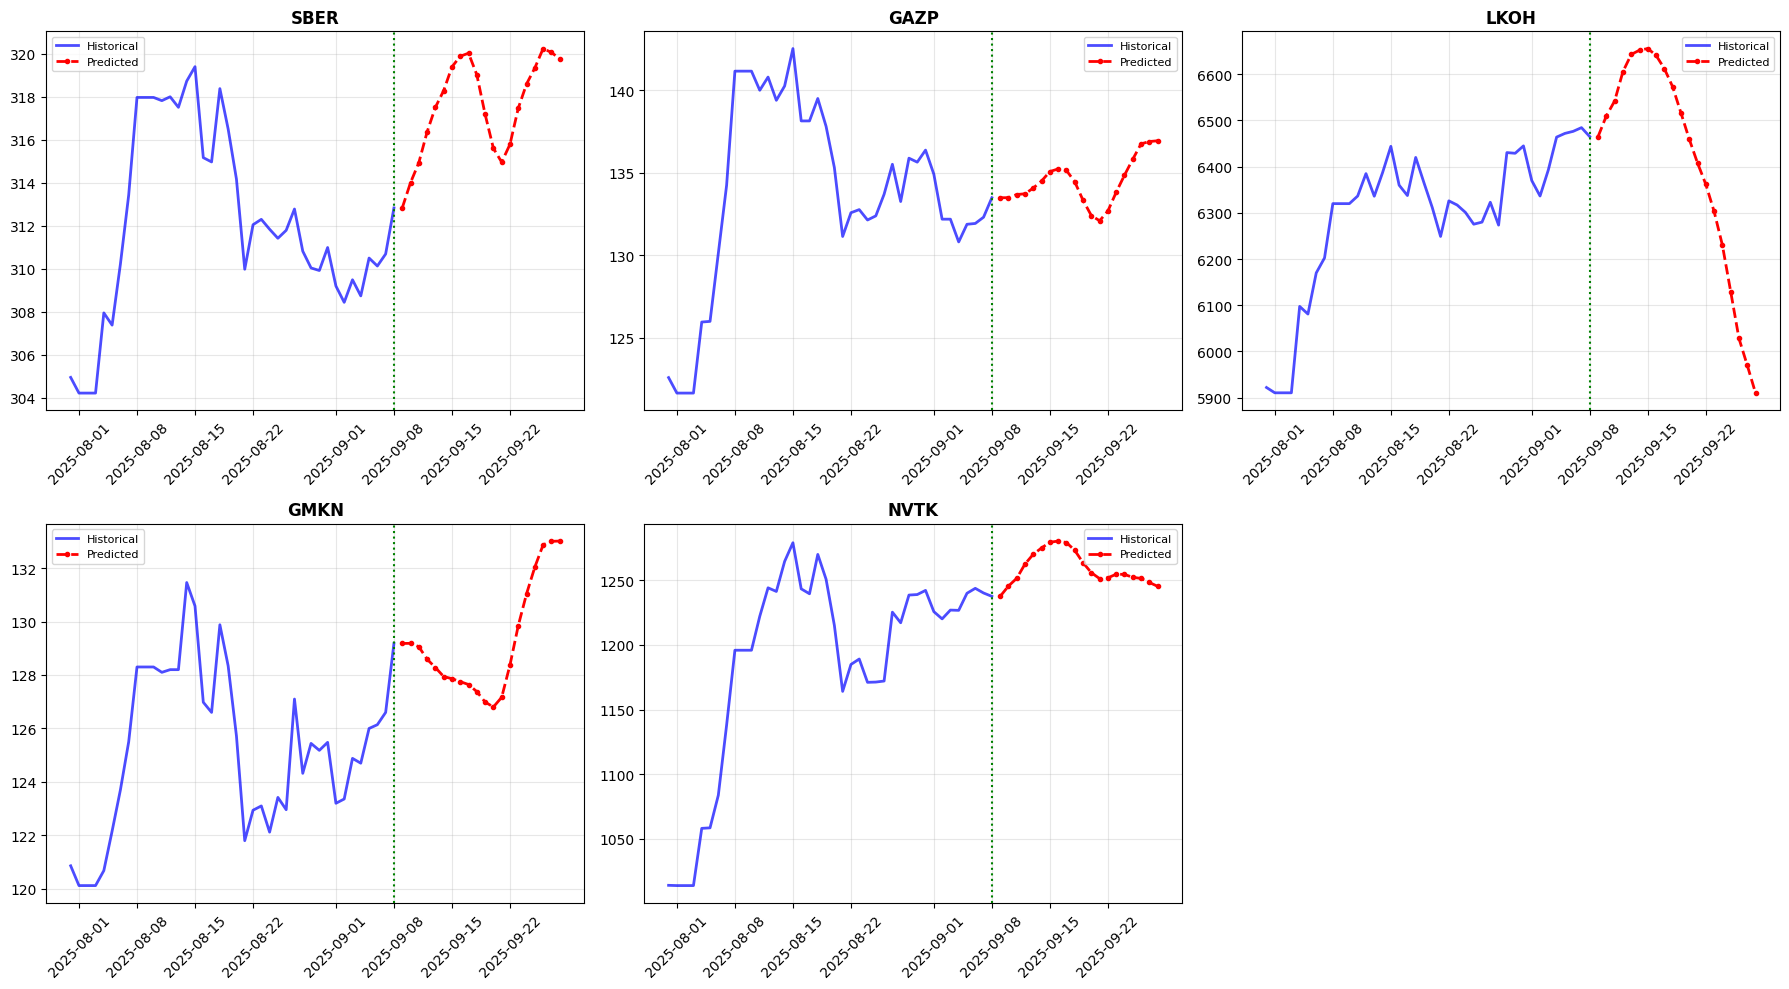

In [8]:
def generate_forecast(
    model, df_ticker, llm_ticker, feature_scaler, date_t,
    clip_pct=0.03, smooth_alpha=0.3, llm_weight=0.2
):
    model.eval()

    df_cut = df_ticker[df_ticker['begin'] <= date_t].copy()
    if len(df_cut) < INPUT_WINDOW:
        return {'R': np.zeros(PRED_HORIZON), 'P': np.zeros(PRED_HORIZON), 'prices': np.zeros(PRED_HORIZON)}

    ds = ImprovedTimeSeriesDataset(
        df_cut,
        llm_ticker,
        seq_len=INPUT_WINDOW,
        pred_horizon=PRED_HORIZON,
        feature_scaler=feature_scaler,
        is_train=False
    )

    if len(ds) == 0:
        return {'R': np.zeros(PRED_HORIZON), 'P': np.zeros(PRED_HORIZON), 'prices': np.zeros(PRED_HORIZON)}

    X, _, _ = ds[-1]
    X = X.unsqueeze(0).to(device)

    # ✅ Взвешиваем LLM-фичи внутри входного тензора
    if hasattr(ds, "llm_feature_indices"):
        X[:, :, ds.llm_feature_indices] *= llm_weight

    with torch.no_grad():
        pred_log_returns, pred_probs = model(X)

    pred_log_returns = pred_log_returns.cpu().numpy().flatten()

    # Ограничиваем амплитуду
    pred_log_returns = np.clip(pred_log_returns, -clip_pct, clip_pct)

    # Экспоненциальное сглаживание
    pred_log_returns = pd.Series(pred_log_returns).ewm(alpha=smooth_alpha).mean().values

    # Формируем прогноз цен
    last_price = df_cut['close'].iloc[-1]
    cum_prices = last_price * np.exp(np.cumsum(pred_log_returns))

    # Финальное сглаживание цен и коррекция по начальному уровню
    smoothed_prices = pd.Series(cum_prices).rolling(window=5, min_periods=1, center=True).mean().values
    smoothed_prices = smoothed_prices / smoothed_prices[0] * last_price

    # Пересчёт доходностей из сглаженных цен
    pred_log_returns = np.log(smoothed_prices[1:] / smoothed_prices[:-1])
    pred_log_returns = np.insert(pred_log_returns, 0, 0)

    return {
        'R': pred_log_returns,
        'P': pred_probs.cpu().numpy().flatten(),
        'prices': smoothed_prices
    }


import matplotlib.pyplot as plt

print("\n📊 7. Визуализация предсказаний для топ-5 тикеров...\n")

top_tickers = ['SBER', 'GAZP', 'LKOH', 'GMKN', 'NVTK']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, ticker in enumerate(top_tickers):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    df_t = CANDLES[CANDLES['ticker'] == ticker].copy()
    llm_ticker = LLM_FEATURES_DF[LLM_FEATURES_DF['ticker'] == ticker].copy()
    
    if len(df_t) < INPUT_WINDOW:
        ax.set_title(f"{ticker} - Not enough data")
        continue

    try:
        forecast = generate_forecast(
            trained_model, df_t, llm_ticker, feature_scaler, TRAIN_CUTOFF
        )
        daily_r = forecast['R']
        pred_prices = [df_t['close'].iloc[-1]]
        for r in daily_r:
            pred_prices.append(pred_prices[-1] * (1 + r))
        pred_prices = np.array(pred_prices[1:])
    except Exception as e:
        ax.set_title(f"{ticker} - Prediction Error: {e}")
        continue

    df_plot = df_t.groupby("begin").agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum"
    }).reset_index()
    df_plot = df_plot.set_index("begin").asfreq("D").ffill()
    
    last_date = df_plot.index[-1]
    pred_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=PRED_HORIZON)
    
    ax.plot(df_plot.index[-40:], df_plot["close"][-40:], 
              label="Historical", linewidth=2, color='blue', alpha=0.7)
    ax.plot(pred_dates, pred_prices, 
              label="Predicted", linestyle="--", linewidth=2, marker='o', markersize=3, color='red')
    ax.axvline(x=last_date, color='green', linestyle=':', linewidth=1.5)
    ax.set_title(f"{ticker}", fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    # Поворот дат на оси X
    ax.tick_params(axis='x', rotation=45)

    
if len(axes) > len(top_tickers):
    for extra_ax in axes[len(top_tickers):]:
        extra_ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
def generate_forecast(
    model, df_ticker, llm_ticker, feature_scaler, date_t,
    clip_pct=0.03, smooth_alpha=0.3, llm_weight=0.2
):
    model.eval()

    df_cut = df_ticker[df_ticker['begin'] <= date_t].copy()
    if len(df_cut) < INPUT_WINDOW:
        return {'R': np.zeros(PRED_HORIZON), 'P': np.zeros(PRED_HORIZON), 'prices': np.zeros(PRED_HORIZON)}

    ds = ImprovedTimeSeriesDataset(
        df_cut,
        llm_ticker,
        seq_len=INPUT_WINDOW,
        pred_horizon=PRED_HORIZON,
        feature_scaler=feature_scaler,
        is_train=False
    )

    if len(ds) == 0:
        return {'R': np.zeros(PRED_HORIZON), 'P': np.zeros(PRED_HORIZON), 'prices': np.zeros(PRED_HORIZON)}

    X, _, _ = ds[-1]
    X = X.unsqueeze(0).to(device)

    # ✅ Взвешиваем LLM-фичи внутри входного тензора
    if hasattr(ds, "llm_feature_indices"):
        X[:, :, ds.llm_feature_indices] *= llm_weight

    with torch.no_grad():
        pred_log_returns, pred_probs = model(X)

    pred_log_returns = pred_log_returns.cpu().numpy().flatten()

    # Ограничиваем амплитуду
    pred_log_returns = np.clip(pred_log_returns, -clip_pct, clip_pct)

    # Экспоненциальное сглаживание
    pred_log_returns = pd.Series(pred_log_returns).ewm(alpha=smooth_alpha).mean().values

    # Формируем прогноз цен
    last_price = df_cut['close'].iloc[-1]
    cum_prices = last_price * np.exp(np.cumsum(pred_log_returns))

    # Финальное сглаживание цен и коррекция по начальному уровню
    smoothed_prices = pd.Series(cum_prices).rolling(window=5, min_periods=1, center=True).mean().values
    smoothed_prices = smoothed_prices / smoothed_prices[0] * last_price

    # Пересчёт доходностей из сглаженных цен
    pred_log_returns = np.log(smoothed_prices[1:] / smoothed_prices[:-1])
    pred_log_returns = np.insert(pred_log_returns, 0, 0)

    return {
        'R': pred_log_returns,
        'P': pred_probs.cpu().numpy().flatten(),
        'prices': smoothed_prices
    }


all_train_tickers = TRAIN_TICKERS  
submission_rows = []

for ticker in tqdm(all_train_tickers, desc="Generating forecasts"):
    df_ticker = CANDLES[CANDLES['ticker'] == ticker].copy()
    llm_ticker = LLM_FEATURES_DF[LLM_FEATURES_DF['ticker'] == ticker].copy()

    df_cut = df_ticker[df_ticker['begin'] <= TRAIN_CUTOFF].copy()
    
    if len(df_cut) < INPUT_WINDOW:
        R = np.zeros(PRED_HORIZON)
    else:
        forecast = generate_forecast(
            trained_model,
            df_cut,
            llm_ticker,
            feature_scaler,
            TRAIN_CUTOFF
        )
        daily_log_r = forecast['R']
        R = np.exp(np.cumsum(daily_log_r)) - 1
    
    submission_rows.append([ticker] + R.tolist())

columns = ['ticker'] + [f'p{i+1}' for i in range(PRED_HORIZON)]
submission_df = pd.DataFrame(submission_rows, columns=columns).set_index('ticker')

print(f"\n Прогнозы готовы для {len(submission_df)} тикеров")
print(submission_df.head())

submission_df.to_csv('forecast_results.csv', index=True)
print(f" Сохранено в: forecast_results.csv")

Generating forecasts: 100%|██████████| 19/19 [00:00<00:00, 23.14it/s]


 Прогнозы готовы для 19 тикеров
         p1        p2        p3        p4        p5        p6        p7  \
ticker                                                                    
AFLT    0.0  0.001195 -0.000229 -0.004033 -0.008038 -0.013076 -0.018067   
ALRS    0.0  0.002345  0.005570  0.009129  0.014308  0.019793  0.028488   
CHMF    0.0  0.007277  0.012734  0.023016  0.029356  0.031488  0.033282   
GAZP    0.0  0.000037  0.001467  0.001803  0.004412  0.007633  0.011921   
GMKN    0.0  0.000037 -0.000936 -0.004552 -0.006968 -0.009565 -0.010196   

              p8        p9       p10       p11       p12       p13       p14  \
ticker                                                                         
AFLT   -0.023215 -0.028293 -0.037011 -0.048415 -0.058156 -0.063238 -0.062118   
ALRS    0.036667  0.044680  0.051479  0.057409  0.063340  0.072371  0.087600   
CHMF    0.032393  0.029918  0.024642  0.017416  0.010920  0.006311  0.004360   
GAZP    0.013117  0.012430  0.007290 -0.0